# Ship
Notebook that deals with the ship data, quality control, etc

## Load modules

In [30]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import glidertools as gt
from tqdm.notebook import tqdm_notebook as tqdm
from cmocean import cm as cmo  
import os
import pathlib
from matplotlib.ticker import MaxNLocator
import geomag
import cartopy.crs as ccrs
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.image as mpimg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
from scipy import stats
#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
from scipy.stats import chi2
from scipy.special import digamma
from scipy.stats import pearsonr
#function for coverting Matlab's datenum into Python's datetime
#from https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
#with modifications to support array input and output

mpl.rcParams['animation.ffmpeg_path'] = r"/Users/xedhjo/Documents/Python/extra/ffmpeg"

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

from IPython.display import display, Markdown

def print_with_font_size(text, fs=20):
    # Format the output with the desired font size
    print_output = f"<span style='font-size: {fs}px;'>{text}</span>"
    display(Markdown(print_output))

print = print_with_font_size

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)
                
def time_ticks_h(ax,interval=[0,6,12,18]):
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
    
def time_ticks_d(ax,majint,minint):
    ax.xaxis.set_minor_locator(mdates.HourLocator(minint))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))
    ax.xaxis.set_major_locator(mdates.DayLocator(majint))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24


def fix_xticks(ax,ds):
    
    if (ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 1 :
        ax[0].xaxis.set_minor_locator(mdates.HourLocator())
        ax[0].xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,3)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        #ax[3].set_xlabel(f"{ds.time[0].values.astype('datetime64[D]')}",loc='left')

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 1) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 7):
        ax[0].xaxis.set_minor_locator(mdates.HourLocator([0,12]))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 6) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 15):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(2,32,2)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        ax[-1].set_xlabel('2023')

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 14) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 31):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator([5,10,15,20,25,30]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        #ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 30):
        ax[0].xaxis.set_major_locator(mdates.MonthLocator())
        ax[0].xaxis.set_minor_locator(mdates.DayLocator([1,5,10,15,20,25]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%B"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    
    rot_ticks(ax[-1],0,'center')



wind_c2 = ListedColormap(['#FCC681','#FF819E','#FF819E','#A0A3E0','#A0A3E0','#99D4E5','#99D4E5','#FCC681']) # Soft pastels, use this

kc = '#006699'
sdc = '#ff6600'
ppc = 'crimson'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/xedhjo/opt/miniconda3/envs/env/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fft', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Load data

In [3]:
import glob
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.dates as mdates
from tqdm.notebook import tqdm_notebook as tqdm

def process_ctd_files(path_to_files, resample=True):
    """
    Process CTD files and create an xarray dataset.

    Parameters:
        path_to_files (str): Path to the CTD files.
        resample (bool): Flag indicating whether to resample the data to 10-minute intervals. Default is True.

    Returns:
        xr.Dataset: Processed CTD data as an xarray dataset.
    """
    tmp = []
    ctd_files = glob.glob(path_to_files)

    # Read and concatenate CTD data from multiple files
    print('Reading the files... 🕵🏼‍♀️')

    for i in tqdm(range(len(ctd_files)-1), desc="Processing CTD files"):
        df = pd.read_csv(ctd_files[i+1], skiprows=3, delim_whitespace=True)
        df['time'] = mdates.num2date([mdates.date2num(np.datetime64(f'2023-03-{str(5+i).zfill(2)}'))] * df.shape[0] + df.index.values / 86400)
        tmp.append(df)
    df = pd.concat(tmp)
    
    
    # Convert time to datetime, set as index, and create xarray dataset
    print('Converting dates... 📆')
    df['time'] = df['time'].dt.tz_localize(None).astype('datetime64[s]')
    df = df.set_index('time')
    ds = df.to_xarray()

    if resample:
        print('Resampling... 🫡')

        # Resample data to 10-minute intervals
        ds = ds.resample(time='10min').mean()

    # Calculate day of year, and mission day, and set them as coordinates
    ds['doy'] = xr.DataArray(mdates.date2num(ds['time']) - mdates.date2num(np.datetime64('2023-01-02')), dims='time')
    ds['mday'] = xr.DataArray(mdates.date2num(ds['time']) - mdates.date2num(ds['time'].values[0]), dims='time')
    ds = ds.set_coords('doy')
    ds = ds.set_coords('mday')

    print('Done 🥸')
    
    return ds

# Process CTD files and create xarray dataset
ds = process_ctd_files('/Volumes/MASSIVEUNIT/Data/QUICCHE/Ship drive copy/metacq/data/2303*.MET', resample=True)

Reading the files... 🕵🏼‍♀️


Processing CTD files:   0%|          | 0/26 [00:00<?, ?it/s]

Converting dates... 📆
Resampling... 🫡
Done 🥸


### Add attributes

In [85]:
# Rename variables, otherwise saving to a netCDF will be difficult
rename_dict = {
    '#Time': 'Time',
    'RH-2': 'RH_2',
    'RT-2': 'RT_2',
    'DP-2': 'DP_2',
    'WS-2': 'WS_2',
    'WD-2': 'WD_2',
    'TW-2': 'TW_2',
    'TI-2': 'TI_2',
    'TT-2': 'TT_2',
    'TC-2': 'TC_2',
    'SA-2': 'SA_2',
    'SD-2': 'SD_2',
    'SV-2': 'SV_2',
    'TG-2': 'TG_2',
    'FI-2': 'FI_2',
    'FI-3': 'FI_3',
    'VP-2': 'VP_2',
    'VR-2': 'VR_2',
    'VH-2': 'VH_2',
    'ZO-2': 'ZO_2',
    'ZS-2': 'ZS_2',
    'ZT-2': 'ZT_2',
    'ZI-2': 'ZI_2',
    'TT-3': 'TT_3',
    'TC-3': 'TC_3',
    'SA-3': 'SA_3',
    'TT-4': 'TT_4',
    'TC-4': 'TC_4',
    'SA-4': 'SA_4'
}

ds = ds.rename(rename_dict)

In [526]:
status_explanation = [
    "0: 'Data Valid - Calibration corrections not applied'",
    "1: 'Data Valid - Calibration corrections applied in Sensor module'",
    "2: 'Data Valid - Calibration corrections applied in Acquisition program'",
    "3: 'Data Valid - Both type 1 and type 2'",
    "7: 'Data Invalid - Out of range'",
    "8: 'Data Invalid - Data Emulated'",
    "9: 'Data Invalid - No Valid Response from Input'"
]

# Air Temperature Sensor
var = 'AT'
ds[var].attrs['module'] = 'TMP28'
ds[var].attrs['module_number'] = 1
ds[var].attrs['sensor'] = 'Air Temperature'
ds[var].attrs['model'] = '41342VC'
ds[var].attrs['serial'] = '27209'
ds[var].attrs['manufacturer'] = 'RM Young'
ds[var].attrs['location'] = "MET Mast 56' above MWL"
ds[var].attrs['installed_height'] = 17
ds[var].attrs['owner'] = 'SIO/STS'
ds[var].attrs['calibration_laboratory'] = 'STS'
ds[var].attrs['calibration_date'] = '20-Oct-2022'
ds[var].attrs['installation_date'] = '28-Oct-2022'
ds[var].attrs['comments'] = ''
ds[var].attrs['write_to_file'] = "True"
ds[var].attrs['number_parameters_returned_from_sensor'] = 1
ds[var].attrs['additional_parameters_computed'] = 0
ds[var].attrs['total'] = 1
ds[var].attrs['parameter_tags'] = 'AT'
ds[var].attrs['at_number'] = 1
ds[var].attrs['seconds_averaged'] = 60.0
ds[var].attrs['units'] = 'Deg C'
ds[var].attrs['long_name'] = 'Air Temperature'
ds[var].attrs['standard_name'] = 'air_temperature'
ds[var].attrs['valid_min'] = -40.0
ds[var].attrs['valid_max'] = 50.0
ds[var].attrs['status'] = '2-OK'
ds[var].attrs['status_explanation'] = status_explanation

# Relative Humidity Sensor
for i, var in enumerate(['RH', 'RT', 'DP', 'RH_2', 'RT_2', 'DP_2']):
    if var in ['RH', 'RT', 'DP']:
        ds[var].attrs['module'] = 'HRH06'
        ds[var].attrs['module_number'] = 1
    else:
        ds[var].attrs['module'] = 'HRH24'
        ds[var].attrs['module_number'] = 2

    ds[var].attrs['sensor'] = 'Relative Humidity'
    ds[var].attrs['model'] = 'EE08'
    ds[var].attrs['serial_number'] = '173305000106A2' if var in ['RH', 'RT', 'DP'] else '17150500023924'
    ds[var].attrs['manufacturer'] = 'E+E Elektronik'
    ds[var].attrs['location'] = "MET Mast 56'above MWL"
    ds[var].attrs['owner'] = 'SIO/STS'
    ds[var].attrs['calibration_lab'] = 'STS'
    ds[var].attrs['calibration_date'] = '25-Oct-2022'
    ds[var].attrs['installation_date'] = '28-Oct-2022'
    ds[var].attrs['comments'] = ''
    ds[var].attrs['write_to_file'] = "True"
    ds[var].attrs['number_parameters_returned_from_sensor'] = 2
    ds[var].attrs['additional_parameters_computed'] = 1
    ds[var].attrs['total'] = 3
    ds[var].attrs['parameter_tags'] = ['RH', 'RT', 'DP']
    ds[var].attrs[['rh_number', 'rt_number', 'dp_number'][i % 3]] = 1 if var in ['RH', 'RT', 'DP'] else 2
    ds[var].attrs['seconds_averaged'] = 60.0 if var in ['RH', 'RT'] else 0
    ds[var].attrs['units'] = 'percent' if var in ['RH', 'RH_2'] else 'degrees Celsius'
    ds[var].attrs['long_name'] = 'Relative Humidity' if var in ['RH', 'RH_2'] else 'Relative Temperature' if var in ['RT', 'RT_2'] else 'Dew-point Temperature'
    ds[var].attrs['standard_name'] = 'relative_humidity' if var in ['RH', 'RH_2'] else 'air_temperature' if var in ['RT', 'RT_2'] else 'dew_point_temperature'
    ds[var].attrs['valid_min'] = 0.0 if var in ['RH', 'RH_2'] else -40.0
    ds[var].attrs['valid_max'] = 100.0 if var in ['RH', 'RH_2'] else 60.0
    ds[var].attrs['status'] = '2-OK'
    ds[var].attrs['status_explanation'] = status_explanation
    ds[var].attrs['installed_height'] = 17

In [527]:
# Wind Sensors

for i, var in enumerate(['WS', 'WD', 'TW', 'TI', 'WS_2', 'WD_2', 'TW_2', 'TI_2']):
    if var in ['WS', 'WD', 'TW', 'TI']:
        ds[var].attrs['module'] = 'WND97'
        ds[var].attrs['module_number'] = 1
    else:
        ds[var].attrs['module'] = 'WND09'
        ds[var].attrs['module_number'] = 2

    ds[var].attrs['sensor'] = 'Wind'
    ds[var].attrs['model'] = '86106' if var in ['WS', 'WD', 'TW', 'TI'] else '5300'
    ds[var].attrs['serial_number'] = '1297' if var in ['WS', 'WD', 'TW', 'TI'] else '17150500023924'
    ds[var].attrs['manufacturer'] = 'RM Young'
    ds[var].attrs['location'] = "MET Mast 56'above MWL" if var in ['WS', 'WD', 'TW', 'TI'] else "Main Mast Starboard Side 82' above MWL"
    ds[var].attrs['owner'] = 'SIO/STS' if var in ['WS', 'WD', 'TW', 'TI'] else 'RV Roger Revelle'
    ds[var].attrs['calibration_lab'] = 'STS' if var in ['WS', 'WD', 'TW', 'TI'] else 'RM Young'
    ds[var].attrs['calibration_date'] = '11-Oct-2022' if var in ['WS', 'WD', 'TW', 'TI'] else '????'
    ds[var].attrs['installation_date'] = '28-Oct-2022' if var in ['WS', 'WD', 'TW', 'TI'] else '1996'
    ds[var].attrs['comments'] = ''
    ds[var].attrs['write_to_file'] = "True"
    ds[var].attrs['number_parameters_returned_from_sensor'] = 2
    ds[var].attrs['additional_parameters_computed'] = 2
    ds[var].attrs['total'] = 4
    ds[var].attrs['parameter_tags'] = ['WS', 'WD', 'TW', 'TI']
    ds[var].attrs[['ws_number', 'wd_number', 'tw_number', 'ti_number'][i % 4]] = 1 if var in ['WS', 'WD', 'TW', 'TI'] else 2
    ds[var].attrs['status'] = '2-OK'
    ds[var].attrs['seconds_averaged'] = 60.0 if var in ['WS', 'WD'] else 0
    ds[var].attrs['units'] = 'm/s' if var in ['WS', 'WS_2', 'TW', 'TW_2'] else 'degrees'
    ds[var].attrs['long_name'] = 'Relative Wind Speed' if var in ['WS', 'WS_2'] else 'Relative Wind Direction' if var in ['WD', 'WD_2'] else 'True Wind Speed' if var in ['TW', 'TW_2'] else 'True Wind Direction'
    ds[var].attrs['standard_name'] = 'relative_wind_speed' if var in ['WS', 'WS_2'] else 'relative_wind_direction' if var in ['WD', 'WD_2'] else 'true_wind_peed' if var in ['TW', 'TW_2'] else 'true_wind_direction'
    ds[var].attrs['valid_min'] = 0.0
    ds[var].attrs['valid_max'] = 500.0 if var in ['WS', 'WS_2', 'TW', 'TW_2'] else 360.0
    ds[var].attrs['status'] = '2-OK'
    ds[var].attrs['status_explanation'] = status_explanation
    ds[var].attrs['installed_height'] = 17 if var in ['WS', 'WD', 'TW', 'TI'] else 25

In [528]:
# Thermosalinograph Sensors

for i, var in enumerate(['TT', 'TC', 'SA', 'SD', 'SV', 'TG', 'TT_2', 'TC_2', 'SA_2', 'SD_2', 'SV_2', 'TG_2']):
    if var in ['TT', 'TC', 'SA', 'SD', 'SV', 'TG']:
        ds[var].attrs['module'] = 'TSG82'
        ds[var].attrs['module_number'] = 1
    else:
        ds[var].attrs['module'] = 'TSG18'
        ds[var].attrs['module_number'] = 2

    ds[var].attrs['sensor'] = 'Thermosalinograph'
    ds[var].attrs['model'] = 'SBE45'
    ds[var].attrs['serial_number'] = '0082' if var in ['TT', 'TC', 'SA', 'SD', 'SV', 'TG'] else '0318'
    ds[var].attrs['manufacturer'] = 'Seabird'
    ds[var].attrs['location'] = 'Bow thruster UCW intake' if var in ['TT', 'TC', 'SA', 'SD', 'SV', 'TG'] else 'Aft Hydro Lab'
    ds[var].attrs['owner'] = 'SIO/STS'
    ds[var].attrs['calibration_lab'] = 'Seabird'
    ds[var].attrs['calibration_date'] = '14-Jul-2022'
    ds[var].attrs['installation_date'] = '30-Oct-2022'
    ds[var].attrs['comments'] = ''
    ds[var].attrs['write_to_file'] = 'True'
    ds[var].attrs['number_parameters_returned_from_sensor'] = 2
    ds[var].attrs['additional_parameters_computed'] = 4
    ds[var].attrs['total'] = 6
    ds[var].attrs['parameter_tags'] = ['TT', 'TC', 'SA', 'SD', 'SV', 'TG']
    ds[var].attrs[['tt_number', 'tc_number', 'sa_number', 'sd_number', 'sv_number', 'tg_number'][i % 6]] = 1 if var in ['TT', 'TC', 'SA', 'SD', 'SV', 'TG'] else 2
    ds[var].attrs['status'] = '2-OK'
    ds[var].attrs['seconds_averaged'] = 60.0 if var in ['TT', 'TC'] else 0
    ds[var].attrs['units'] = 'Deg C' if var in ['TT', 'TT_2'] else 'mS/cm' if var in ['TC', 'TC_2'] else 'PSU' if var in ['SA', 'SA_2'] else 'Kg/m^3' if var in ['SD', 'SD_2'] else 'm/s' if var in ['SV', 'SV_2'] else ''
    ds[var].attrs['long_name'] = 'Thermosalinograph Temperature' if var in ['TT', 'TT_2'] else 'Thermosalinograph Conductivity' if var in ['TC', 'TC_2'] else 'Salinity' if var in ['SA', 'SA_2'] else 'Sigma_t' if var in ['SD', 'SD_2'] else 'Sound Velocity' if var in ['SV', 'SV_2'] else 'Thermosalinograph Conductivity'
    ds[var].attrs['standard_name'] = 'sea_water_temperature' if var in ['TT', 'TT_2'] else 'sea_water_electrical_conductivity' if var in ['TC', 'TC_2'] else 'sea_water_salinity' if var in ['SA', 'SA_2'] else 'sea_water_density' if var in ['SD', 'SD_2'] else 'sound_velocity' if var in ['SV', 'SV_2'] else 'sea_water_electrical_conductivity'
    ds[var].attrs['valid_min'] = -5.0e0 if var in ['TT', 'TT_2'] else -5.0e0 if var in ['TC', 'TC_2'] else 0.0e0 if var in ['SA', 'SA_2'] else -1.0e1 if var in ['SD', 'SD_2'] else 1.0e3 if var in ['SV', 'SV_2'] else -1.0e10 if var in ['TG', 'TG_2'] else ''
    ds[var].attrs['valid_max'] = 5.0e1 if var in ['TT', 'TT_2'] else 1.0e5 if var in ['TC', 'TC_2'] else 1.0e2 if var in ['SA', 'SA_2'] else 7.0e3 if var in ['SD', 'SD_2'] else 2.0e3 if var in ['SV', 'SV_2'] else 1.0e10 if var in ['TG', 'TG_2'] else ''
    ds[var].attrs['status_explanation'] = status_explanation
    ds[var].attrs['installed_height'] = "????"

In [529]:
# Surface Temperature Sensor
var = 'ST'
ds[var].attrs['module'] = 'SST53'
ds[var].attrs['module_number'] = 1
ds[var].attrs['sensor'] = 'Sea Surface Temperature'
ds[var].attrs['model'] = 'SBE38'
ds[var].attrs['serial'] = '1188'
ds[var].attrs['manufacturer'] = 'Seabird'
ds[var].attrs['location'] = "Bow thruster UCW intake"
ds[var].attrs['installed_height'] = "????"
ds[var].attrs['owner'] = 'SIO/STS'
ds[var].attrs['calibration_laboratory'] = 'STS'
ds[var].attrs['calibration_date'] = '05-Jan-2021'
ds[var].attrs['installation_date'] = '27-May-2021'
ds[var].attrs['comments'] = ''
ds[var].attrs['write_to_file'] = "True"
ds[var].attrs['number_parameters_returned_from_sensor'] = 1
ds[var].attrs['additional_parameters_computed'] = 0
ds[var].attrs['total'] = 1
ds[var].attrs['parameter_tags'] = 'ST'
ds[var].attrs['st_number'] = 1
ds[var].attrs['seconds_averaged'] = 60.0
ds[var].attrs['units'] = 'Deg C'
ds[var].attrs['long_name'] = 'Sea Surface Temperature'
ds[var].attrs['standard_name'] = 'sea_water_temperature'
ds[var].attrs['valid_min'] = -5.0
ds[var].attrs['valid_max'] = 50.0
ds[var].attrs['status'] = '1-OK'
ds[var].attrs['status_explanation'] = status_explanation

In [530]:
# Attitude sensor (for heading)
for i, var in enumerate(['SH', 'SM', 'SR']):
    
    ds[var].attrs['module'] = 'ASH01'
    ds[var].attrs['module_number'] = 1
    ds[var].attrs['sensor'] = 'Attitude'
    ds[var].attrs['model'] = 'ABX-Two'
    ds[var].attrs['serial_number'] = '544C02743'
    ds[var].attrs['manufacturer'] = 'Trimble'
    ds[var].attrs['location'] = "Bridge starboard"
    ds[var].attrs['owner'] = 'SIO/STS'
    ds[var].attrs['calibration_lab'] = 'n/a'
    ds[var].attrs['calibration_date'] = '24-Oct-2020'
    ds[var].attrs['installation_date'] = '15-Oct-2020'
    ds[var].attrs['comments'] = ''
    ds[var].attrs['write_to_file'] = "True"
    ds[var].attrs['number_parameters_returned_from_sensor'] = 3
    ds[var].attrs['additional_parameters_computed'] = 0
    ds[var].attrs['total'] = 3
    ds[var].attrs['parameter_tags'] = ['SH', 'SM', 'SR']
    ds[var].attrs[['sh_number', 'sm_number', 'sr_number'][i % 3]] = 1
    ds[var].attrs['seconds_averaged'] = 0.0
    ds[var].attrs['units'] = 'degrees'
    ds[var].attrs['long_name'] = 'Heading' if var in ['SH'] else 'Pitch' if var in ['SM'] else 'Roll'
    ds[var].attrs['standard_name'] = 'Heading' if var in ['SH'] else 'pitch' if var in ['SM'] else 'poll'
    ds[var].attrs['valid_min'] = 0 if var in ['SH'] else -1e10
    ds[var].attrs['valid_max'] = 360 if var in ['SH'] else 1e10
    ds[var].attrs['status'] = '1-OK'
    ds[var].attrs['status_explanation'] = status_explanation

In [531]:
# Longwave radiation sensor
for i, var in enumerate(['LD', 'LB', 'LT', 'LW']):
    
    ds[var].attrs['module'] = 'LWR21'
    ds[var].attrs['module_number'] = 1
    ds[var].attrs['sensor'] = 'Long Wave Radiation'
    ds[var].attrs['model'] = 'PIR'
    ds[var].attrs['serial_number'] = '38301F3'
    ds[var].attrs['manufacturer'] = 'Eppley Labs'
    ds[var].attrs['location'] = "MET Mast 68'above MWL"
    ds[var].attrs['owner'] = 'SIO/STS'
    ds[var].attrs['calibration_lab'] = 'Eppley'
    ds[var].attrs['calibration_date'] = '05-Oct-2022'
    ds[var].attrs['installation_date'] = '27-Oct-2022'
    ds[var].attrs['comments'] = ''
    ds[var].attrs['write_to_file'] = "True"
    ds[var].attrs['number_parameters_returned_from_sensor'] = 3
    ds[var].attrs['additional_parameters_computed'] = 1
    ds[var].attrs['total'] = 4
    ds[var].attrs['parameter_tags'] = ['LD', 'LB', 'LT', 'LW']
    ds[var].attrs[['ld_number', 'lb_number', 'lt_number', 'lw_number'][i % 4]] = 1
    ds[var].attrs['seconds_averaged'] = 0.0
    ds[var].attrs['units'] = 'degrees' if var in ['LD', 'LB'] else 'uv' if var in ['LT'] else 'W/m2'
    ds[var].attrs['long_name'] = 'Long Wave Radiation Dome Temperature' if var in ['LD'] else 'Long Wave Radiation Body Temperature' if var in ['LB'] else 'Long Wave Radiation Thermopile Volts' if var in ['LT'] else 'Long Wave Radiation'
    ds[var].attrs['standard_name'] = 'longwave_radiation_dome_temperature' if var in ['LD'] else 'longwave_radiation_body_temperature' if var in ['LB'] else 'longwave_radiation_thermopile_volts' if var in ['LT'] else 'longwave_radiation'
    ds[var].attrs['valid_min'] = -1e10 if var in ['LD', 'LB'] else -1e5
    ds[var].attrs['valid_max'] = 1e5
    ds[var].attrs['status'] = '1-OK'
    ds[var].attrs['status_explanation'] = status_explanation

In [532]:
# Shortwave radiation sensor
var = 'SW'

ds[var].attrs['module'] = 'SWR21'
ds[var].attrs['module_number'] = 1
ds[var].attrs['sensor'] = 'Short Wave Radiation'
ds[var].attrs['model'] = 'SPP'
ds[var].attrs['serial_number'] = '38361F3'
ds[var].attrs['manufacturer'] = 'Eppley Labs'
ds[var].attrs['location'] = "MET Mast 68'above MWL"
ds[var].attrs['owner'] = 'SIO/STS'
ds[var].attrs['calibration_lab'] = 'Eppley Labs'
ds[var].attrs['calibration_date'] = '03-Oct-2022'
ds[var].attrs['installation_date'] = '27-Oct-2022'
ds[var].attrs['comments'] = ''
ds[var].attrs['write_to_file'] = "True"
ds[var].attrs['number_parameters_returned_from_sensor'] = 1
ds[var].attrs['additional_parameters_computed'] = 0
ds[var].attrs['total'] = 1
ds[var].attrs['parameter_tags'] = ['SW']
ds[var].attrs['sw_number'] = 1
ds[var].attrs['seconds_averaged'] = 0.0
ds[var].attrs['units'] = 'W/m2'
ds[var].attrs['long_name'] = 'Shortwave Radiation'
ds[var].attrs['standard_name'] = 'shortwave_radiation'
ds[var].attrs['valid_min'] = -5.0e1
ds[var].attrs['valid_max'] = 5.0e4
ds[var].attrs['status'] = '2-OK'
ds[var].attrs['status_explanation'] = status_explanation

In [ ]:
ds.to_netcdf('/Users/xedhjo/Documents/Projects/QUICCHE/data/met_data.nc')

In [525]:
ds = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/met_data.nc')

### Parameters

| Number | Parameter | Description                                  | Units                                      |
|--------|-----------|----------------------------------------------|--------------------------------------------|
| 0      | **AT**        | **Air Temperature**                              | Deg C                                      |
| 1      | **BP**        | **Barometric Pressure**                          | millibars (mb)                             |
| 2      | BC        | Barometric Pressure Temp                     | Deg C                                      |
| 3      | **SW**        | **Short Wave Radiation (SWR)**                   | W/M^2 (Pyranometer)                        |
| 4      | **LW**        | **Long Wave Radiation (LWR)**                    | W/M^2 (Pyrgeometer)                        |
| 5      | LD        | LWR Dome Temperature                         | Deg K                                      |
| 6      | LB        | LWR Body Temperature                         | Deg K                                      |
| 7      | LT        | LWR Thermopile Volts                         |                                            |
| 8      | PR        | Precipitation                                | millimeters (mm)                           |
| 9      | PT        | Precipitation                                | mm/hr                                      |
| 10     | **RH**        | **Relative Humidity**                            | %RH                                        |
| 11     | **RT**        | **Air Temp (RH module)**                         | Deg C                                      |
| 12     | DP        | Dew Point                                    | Deg C                                      |
| 13     | WS        | Rel Wind Speed                               | M/S                                        |
| 14     | WK        | Rel Wind Speed                               | Knots                                      |
| 15     | **TW**        | **True Wind Speed**                              | M/S                                        |
| 16     | TK        | True Wind Speed                              | Knots                                      |
| 17     | WD        | Rel Wind Direction                           | Deg (Direction wind is coming from)        |
| 18     | **TI**        | **True Wind Direction**                          | Deg (Direction wind is coming from)        |
| 19     | **ST**        | **Sea Surface Temperature**                      | Deg C                                      |
| 20     | **TT**        | **Thermosalinograph Temperature**                | Deg C                                      |
| 21     | **TC**        | **Thermosalinograph Conductivity**               | milliSiemens per centimeter (mS/cm)        |
| 22     | **SA**        | **Salinity**                                     | PSU                                        |
| 23     | SD        | Sigma-t                                      | Kg/m^3                                     |
| 24     | SV        | Sound Vel (Chen/Millero)                     | M/S                                        |
| 25     | OX        | Oxygen                                       | ml/l                                       |
| 26     | OG        | Oxygen                                       | mg/l                                       |
| 27     | OC        | Oxygen Current                               | ua                                         |
| 28     | OT        | Oxygen Temperature                           | Deg C                                      |
| 29     | OS        | Oxygen Saturation                            | value ml/l                                 |
| 30     | PH        | Alkalinity (pH)                              |                                            |
| 31     | FL        | Fluorometer                                  | ug/l                                       |
| 32     | TB        | Turbidity                                    | NTU                                        |
| 33     | TR        | Transmissometer                              | %                                          |
| 34     | BA        | Beam Attenuation                             |                                            |
| 35     | PA        | Surface PAR                                  | uE/Second/Meter^2                          |
| 36     | FM        | USW Flow Meter                               | GPM                                        |
| 37     | FI        | USW Flow Meter                               | LPM                                        |
| 38     | VT        | Volts                                        | Volts                                      |
| 39     | MA        | Current                                      | m/a                                        |
| 40     | WT        | Auxiliary water Temp                         | Deg C                                      |
| 41     | AX        | Auxiliary Air Temperature                    | Deg C                                      |
| 42     | PS        | Pressure                                     | PSI                                        |
| 43     | XX        | Unspecified                                  |                                            |
| 44     | LA        | Latitude                                     | Decimal format Deg                         |
| 45     | LO        | Longitude                                    | Decimal format Deg                         |
| 46     | CR        | Ships Course (GPS COG)                       | Deg                                        |
| 47     | SP        | Ship’s Speed (GPS SOG)                       | Knots                                      |
| 48     | SL        | Ship’s Speed Log –Longitudinal               | Knots                                      |
| 49     | SX        | Speed Log – Transverse                       | Knots                                      |
| 50     | GY        | Ships Heading (Gyrocompass)                  | Deg                                        |
| 51     | GT        | GPS Time of Day GMT                          | Secs 0-86400                               |
| 52     | TS        | Time Server Time of Day GMT                  | Secs 0-86400                               |
| 53     | ZD        | GPS DateTime GMT                             | Secs Since 00:00:00 01/01/1970             |
| 54     | GA        | GPS Altitude                                 | Meters above/below Mean Sealevel            |
| 55     | GS        | GPS Status/Number Satellites                 | 1st digit – Status (see below) Last two digits – Number satellites |
| 56     | SY        | System DateTime GMT                          | Secs Since 00:00:00 01/01/1970             |
| 57     | BT        | Bottom Depth                                 | Meters                                     |
| 58     | **SH**        | **Ashtech Heading**                              | Deg                                        |
| 59     | SM        | Ashtech Pitch                                | Deg                                        |
| 60     | SR        | Ashtech Roll                                 | Deg                                        |
| 61     | ZO        | Winch Wire Out                               | Meters                                     |
| 62     | ZS        | Winch Speed                                  | MPM                                        |
| 63     | ZT        | Winch Tension                                | LBS                                        |
| 64     | VP        | VRU Pitch                                    | Deg                                        |
| 65     | VR        | VRU Roll                                     | Deg                                        |
| 66     | VH        | VRU Heave                                    | Meters                                     |
| 67     | VY        | Ship’s List                                  | Deg                                        |
| 68     | VX        | Ship’s Trim                                  | Deg                                        |
| 69     | RX        | Accelerometer X                              | Meters/Second                              |
| 70     | RY        | Accelerometer Y                              | Meters/Second                              |
| 71     | RZ        | Accelerometer Z                              | Meters/Second                              |
| 72     | IP        | CTD Depth                                    | Meters                                     |
| 73     | IT        | CTD Temperature                              | Deg C                                      |
| 74     | IS        | CTD Salinity                                 | PSU                                        |
| 75     | IA        | CTD Altimeter                                | Meters                                     |
| 76     | IV        | CTD Velocity                                 | Meters/Second                              |
| 77     | IX        | Instrumentation Aux                          |                                            |
| 78     | PZ        | UCW Pump Status                              | ON/OFF                                     |
| 79     | TG        | Thermosalinograph Conductivity               | MilliSiemens per cm (ms/cm)                 |
| 80     | MB        | Multibeam Depth                              | Meters                                     |
| 81     | BS        | Barometric Pressure Sealevel                  | Millibars (mb)                             |
| 82     | PC        | pCO2 (partial pressure of CO2)                | Micro-atmospheres                          |
| 83     | AF        | Air Temperature (Deg F)                       | Deg F                                      |
| 84     | WC        | Wind Chill (Deg C)                           | Deg C                                      |
| 85     | WF        | Wind Chill (Deg F)                           | Deg F                                      |
| 86     | LF        | Depth Sounder (3.5Khz)                       | Meters (Below Surface)                     |
| 87     | HF        | Depth Sounder (12Khz)                        | Meters (Below Surface)                     |
| 88     | MG        | Magnetometer                                 | nanoTesla                                  |
| 89     | MD        | Magnetometer Depth                           | Meters (Below Surface)                     |
| 90     | MS        | Magnetometer Status                          | Signal Strength (>80 = good)               |
| 91     | GV        | Gravity                                      | mGal                                       |
| 92     | GC        | Gravity Counts                               | Counts                                     |
| 93     | FB        | Fluorometer Optical Brighteners              | PPB                                        |
| 94     | FO        | Fluorometer Oil                              | PPB                                        |
| 95     | FF        | Fluorometer Fuel                             | PPB                                        |
| 96     | FT        | Fluorometer Temperature                      | Deg C                                      |
| 97     | SF        | Sea Surface Temperature                      | Deg F                                      |
| 98     | TF        | Thermosalinograph Temperature                | Deg F                                      |
| 99     | RF        | Air Temp (RH module)                         | Deg F                                      |
| 100    | DF        | Dew Point                                    | Deg F                                      |
| 101    | WB        | Wet Bulb Temperature                         | Deg C                                      |
| 102    | WF        | Wet Bulb Temperature                         | Deg F                                      |
| 103    | ZI        | Winch ID                                     | Winch LAN numbers 1 thru 9                 |
| 104    | OM        | Oxygen                                       | um/kg3                                     |
| 105    | OF        | UCW Overflow                                 | 0=Normal condition 1=Overflow              |


We want to save `AT, ,BP, RH, RT, TW, TI, ST, TT, TC, TA, SH, LW, SW`

In [533]:
var_to_save = ['AT', 'BP', 'RH', 'RT', 'TW', 'TI', 'ST', 'TT', 'TC', 'SA', 'SH', 'RH_2', 'RT_2', 'TW_2', 'TI_2', 'TT_2', 'TC_2', 'SA_2', 'SW', 'LW', 'LA', 'LO']
ds = ds[var_to_save]

## Comparing the duplicated sensors

### Temperature

### Compare the differences between the different temperature probes

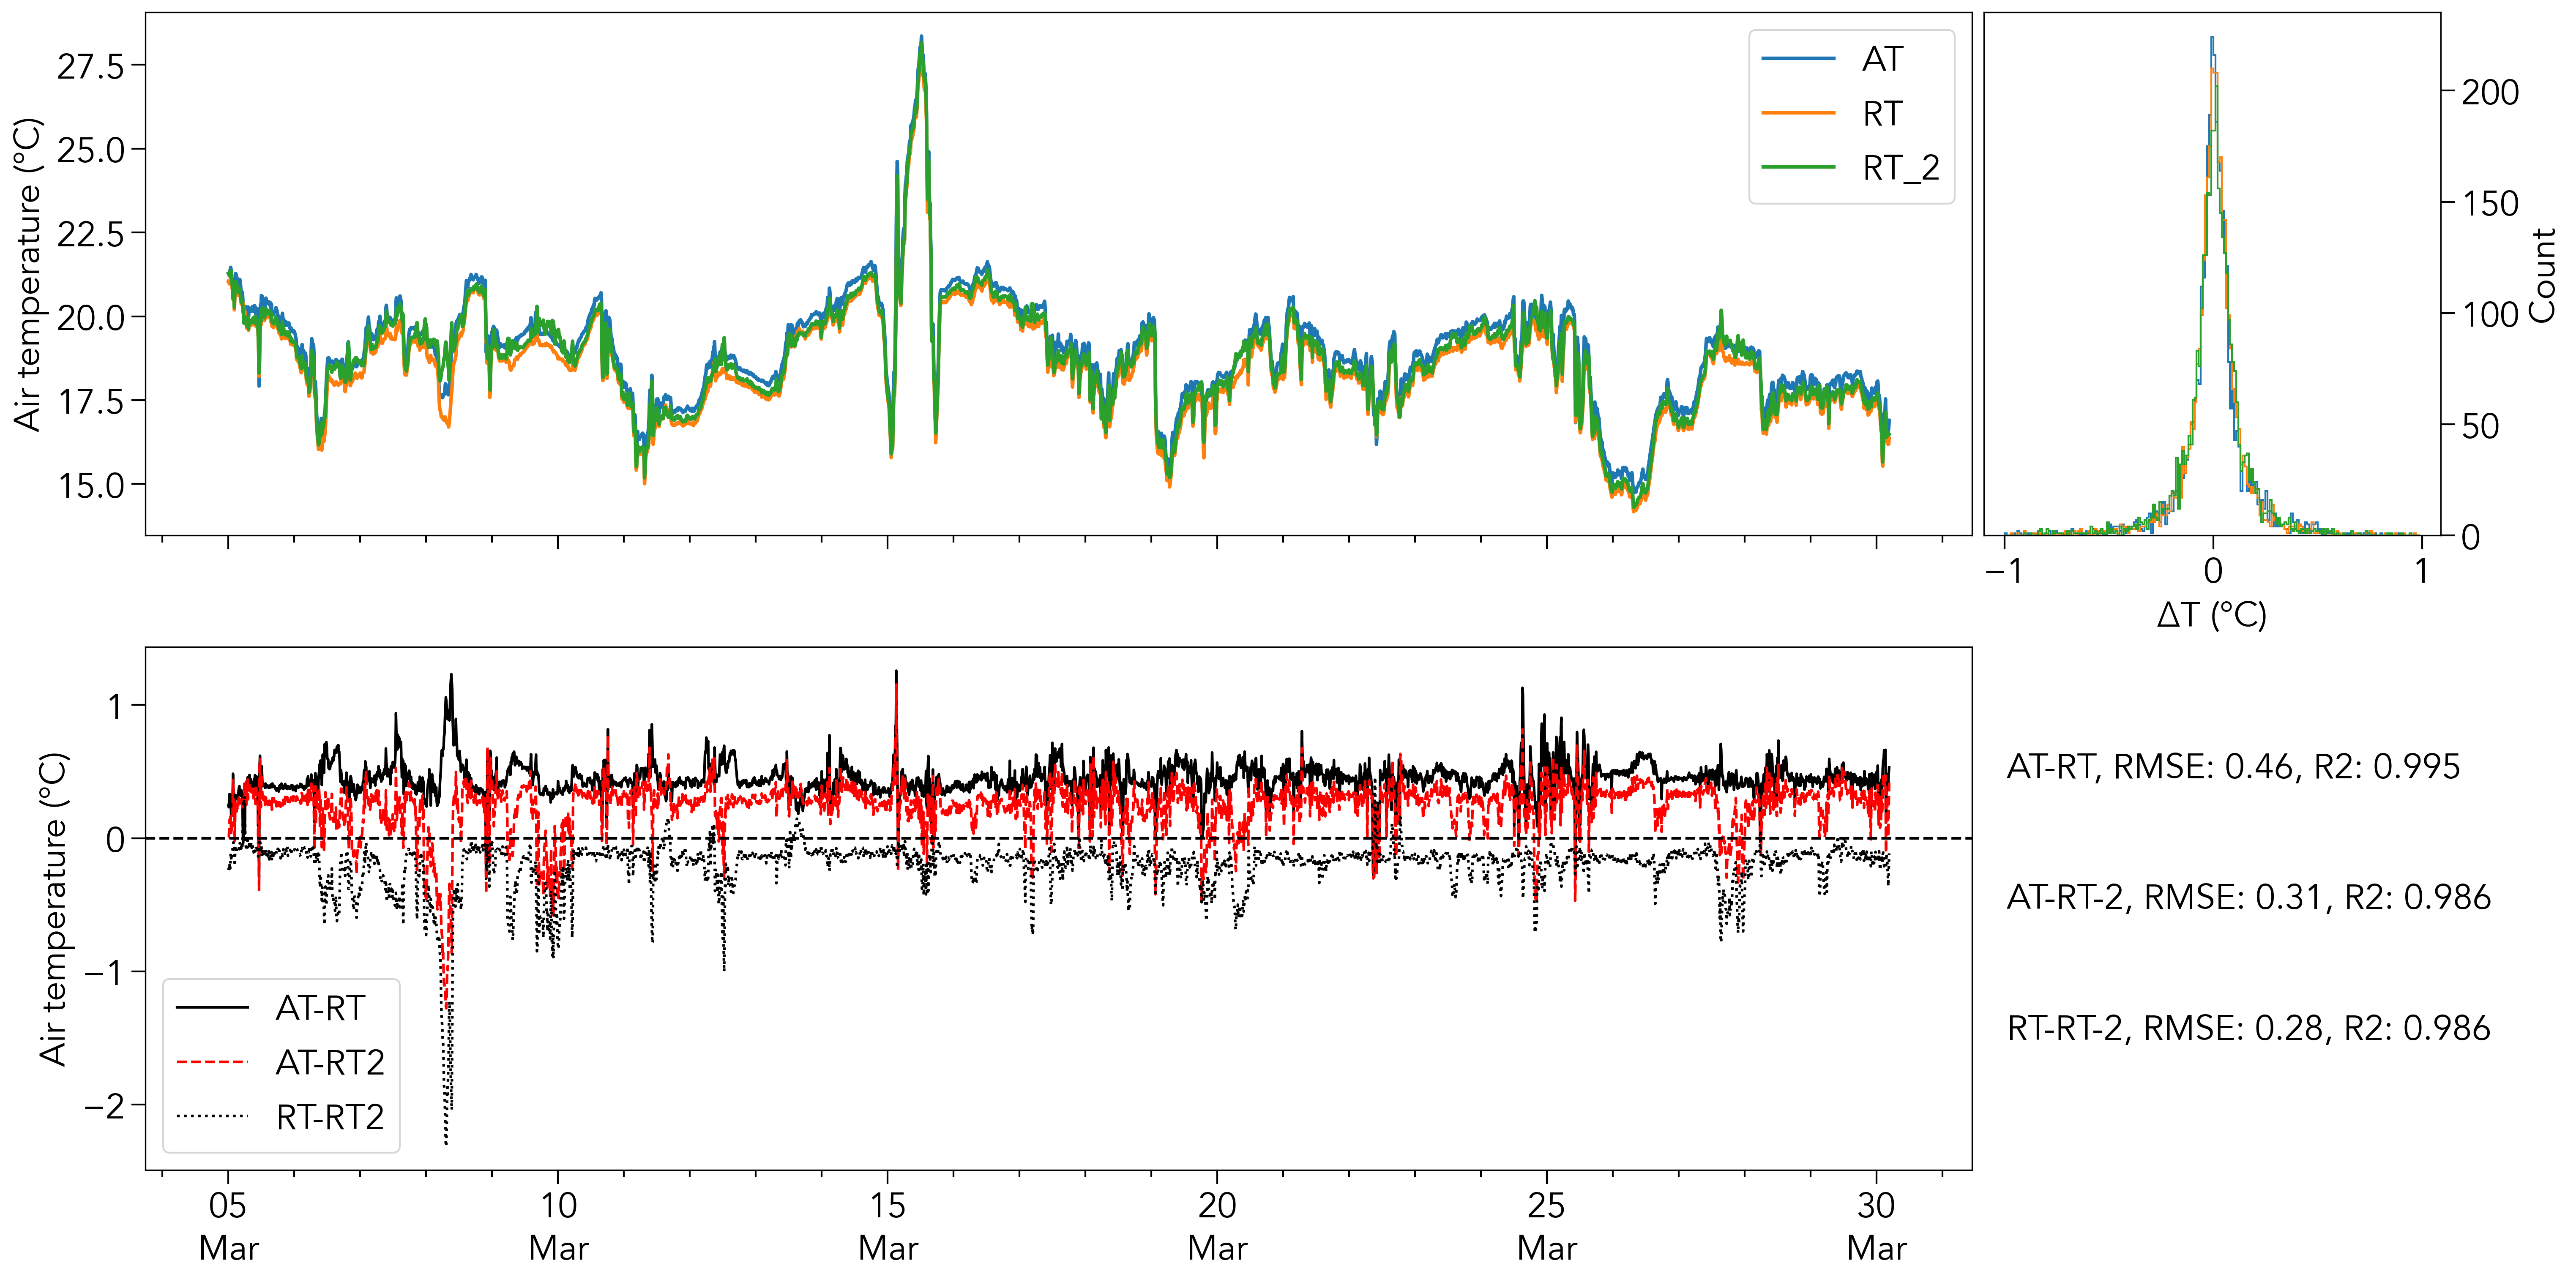

In [174]:
figprops = dict(figsize=(20, 10), dpi=300)
fig = plt.figure(layout="constrained",**figprops)
spec = fig.add_gridspec(nrows=2,ncols=5)

ax = fig.add_subplot(spec[0, :4])
cx = fig.add_subplot(spec[0, 4])
bx = fig.add_subplot(spec[1, :4],sharex=ax)
dx = fig.add_subplot(spec[1, 4])

variables = ['AT','RT','RT_2']

for i,var in enumerate(variables):
    ds[var].plot(ax=ax,label=var,lw=2)

    if i < 1:
        (ds[var]-ds[variables[1]]).plot(ax=bx,label='AT-RT',c='k',ls='-')
        (ds[var]-ds[variables[2]]).plot(ax=bx,label='AT-RT2',c='r',ls='--')
    
    cx.hist(ds[var].diff('time').values, label=var, histtype='step', bins=np.arange(-1,1,0.01))


cx.set(ylabel='Count', xlabel='ΔT (°C)')

(ds[variables[1]]-ds[variables[2]]).plot(ax=bx,label='RT-RT2',c='k',ls=':')

dx.text(0.05,0.75,f"AT-RT, RMSE: {calc_rmse(ds,'AT','RT')}, R2: {(pearsonr(ds['AT'],ds['RT']).statistic**2).round(3)}")
dx.text(0.05,0.5,f"AT-RT-2, RMSE: {calc_rmse(ds,'AT','RT_2')}, R2: {(pearsonr(ds['AT'],ds['RT_2']).statistic**2).round(3)}")
dx.text(0.05,0.25,f"RT-RT-2, RMSE: {calc_rmse(ds,'RT','RT_2')}, R2: {(pearsonr(ds['RT'],ds['RT_2']).statistic**2).round(3)}")
dx.axis('off')

bx.axhline(0,ls='--',c='k')

ax.set(xlabel='', ylabel='Air temperature (°C)')
bx.set(xlabel='', ylabel='Air temperature (°C)')
ax.legend()
bx.legend()
cx.yaxis.tick_right()
cx.yaxis.set_label_position("right")
plt.setp(ax.get_xticklabels(), visible=False)


fix_xticks([bx],ds)
spec.update(hspace=-10)
plt.show()

|Type|Measuring range|Accuracy|
|---|--:|--:|
|AT|-50 to +50°C|±0.3°C at 0°C|
|RT|-40 to +80°C|±0.2°C at 20°C|
|T9602|-20 to +70°C|±0.5°C at 25°C|
|Airmar|-40 to +80°C|±1.1°C at 20°C|


In [124]:
def calc_rmse(ds,var1,var2):
    return np.sqrt(np.square(ds[var1] - ds[var2]).mean()).round(2).values

In [138]:
print(f"AT-RT, RMSE: {calc_rmse(ds,'AT','RT')}, R2: {(pearsonr(ds['AT'],ds['RT']).statistic**2).round(3)}",40)
print(f"AT-RT-2, RMSE: {calc_rmse(ds,'AT','RT_2')}, R2: {(pearsonr(ds['AT'],ds['RT_2']).statistic**2).round(3)}",40)
print(f"RT-RT-2, RMSE: {calc_rmse(ds,'RT','RT_2')}, R2: {(pearsonr(ds['RT'],ds['RT_2']).statistic**2).round(3)}",40)

<span style='font-size: 40px;'>AT-RT, RMSE: 0.46, R2: 0.995</span>

<span style='font-size: 40px;'>AT-RT-2, RMSE: 0.31, R2: 0.986</span>

<span style='font-size: 40px;'>RT-RT-2, RMSE: 0.28, R2: 0.986</span>

In [43]:
print('Which one to choooooose?!',30)

<span style='font-size: 30px;'>Which one to choooooose?!</span>

They're all in the same place

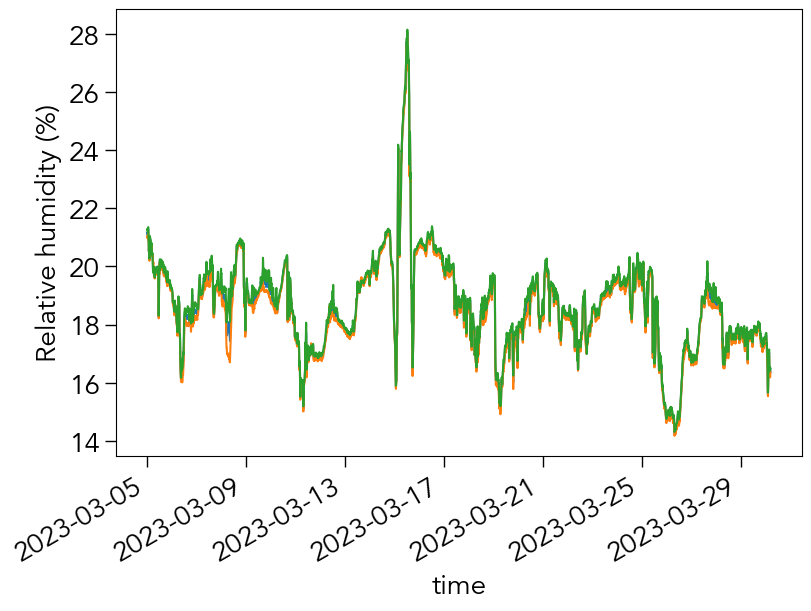

In [180]:
fig,ax = plt.subplots(1, 1, figsize=(8,6), sharex=True, constrained_layout=True)

((ds['RT']+ds['RT_2'])/2).plot(ax=ax)
ds['RT'].plot(ax=ax)
ds['RT_2'].plot(ax=ax)

ax.set(ylabel='Relative humidity (%)')

plt.show()

In [186]:
def correct_wind_speed(ds, var, z):
    
    """
    Corrects wind speed measurements based on the height difference between measurement height (Z_m)
    and reference height (Z).

    Parameters:
    - ds (xarray.Dataset): Dataset containing the wind speed variable.
    - var (str): Name of the wind speed variable in the dataset.
    - z (float): Measurement height (Z_m) in meters.

    Returns:
    - corrected_wind_speed (xarray.DataArray): Wind speed corrected for the height difference.

    """

    # Extract wind speed data from the dataset
    U_Zm = ds[var].values

    # Define reference heights
    Z = 10
    Z_m = z

    # Define roughness length
    Z_0 = 1.52 * 1e-4

    # Apply the correction formula
    corrected_wind_speed = U_Zm * (np.log(Z / Z_0)) / (np.log(Z_m / Z_0))

    return corrected_wind_speed

In [187]:
ds['ws10'] = ('time'), correct_wind_speed(ds,'TW',17)

In [188]:
ds['ws10'].

<xarray.DataArray 'ws10' (time: 3629)>
array([5.08225287, 5.14619458, 4.83825638, ..., 2.24941225, 4.03739436,
       6.78168352])
Coordinates:
  * time     (time) datetime64[ns] 2023-03-05 ... 2023-03-30T04:40:00
    doy      (time) float64 ...

## Wind

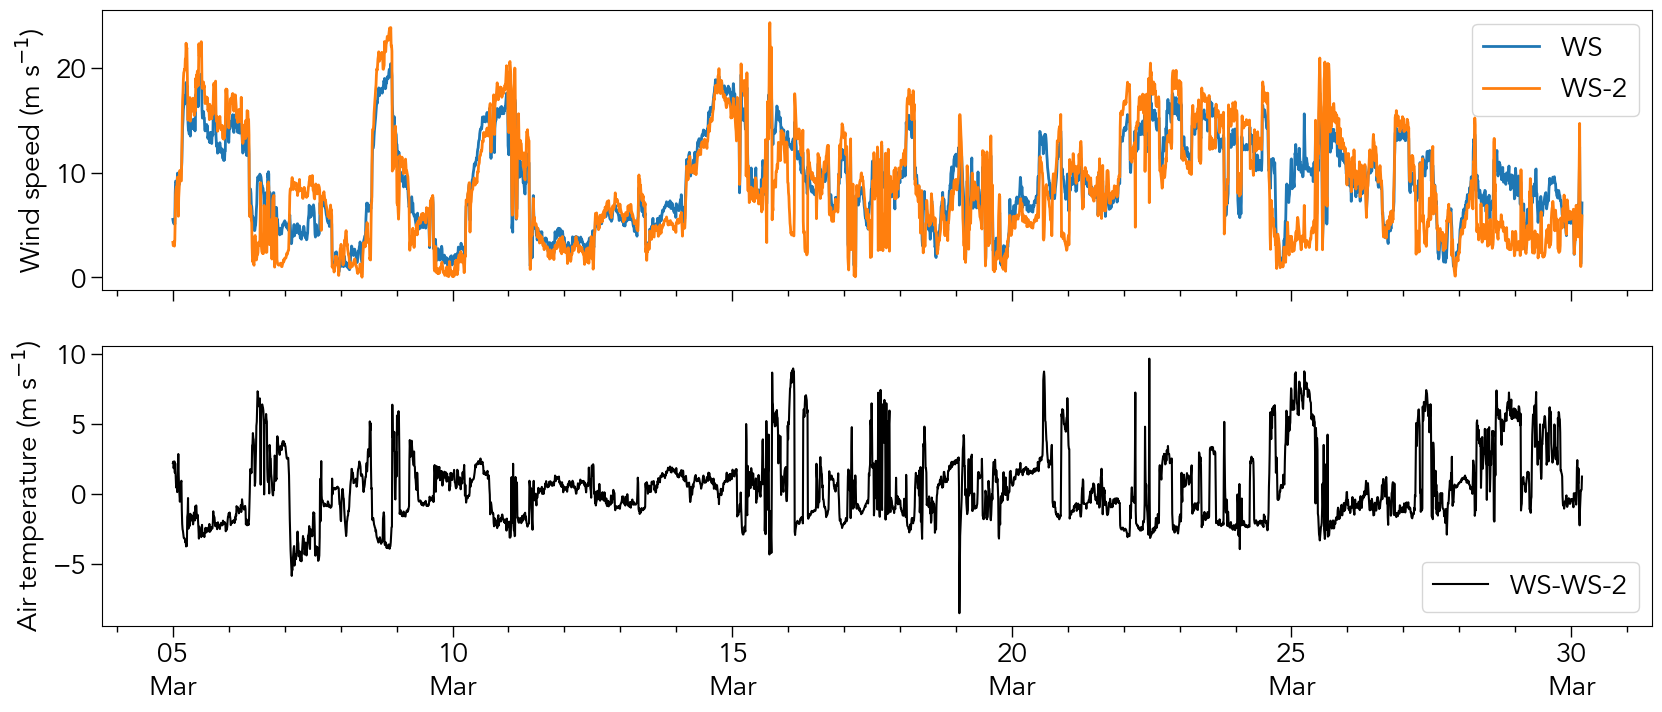

In [44]:
fig, (ax,bx) = plt.subplots(2, 1, figsize=(20,8), sharex=True)

variables = ['WS','WS-2']

for i,var in enumerate(variables):
    ds[var].plot(ax=ax,label=var,lw=2)

    if i < 1:
        (ds[var]-ds[variables[1]]).plot(ax=bx,label='WS-WS-2',c='k',ls='-')

ax.set(xlabel='', ylabel='Wind speed (m s$^{-1}$)')
bx.set(xlabel='', ylabel='Air temperature (m s$^{-1}$)')
ax.legend()
bx.legend()


fix_xticks([bx],ds)

plt.show()

|Variable|Location|
|---|---|
| WS | MET Mast 56'above MWL |
| WS-2 | Main Mast Starboard Side 82'above MWL |

In [48]:
print(56 * 0.3048)
print(82 * 0.3048)

<span style='font-size: 20px;'>17.0688</span>

<span style='font-size: 20px;'>24.9936</span>

In [45]:
print(f"WS-WS-2, RMSE: {calc_rmse(ds,'WS','WS-2')}, R2: {pearsonr(ds['WS'],ds['WS-2']).statistic.round(3)}")

<span style='font-size: 20px;'>WS-WS-2, RMSE: 2.55, R2: 0.882</span>

## COARE

In [189]:
"""
Functions for COARE model version 3.6 bulk flux calculations.
Translated from MATLAB scripts written by Jim Edson and Chris Fairall, 
further edited by Elizabeth Thompson. Main Matalb script source is coare36vn_zrf_et.m
Execute '%run coare36vn_zrf_et' from the iPython command line for test run with
'test_36_data.txt' input data file. 
Code can also be imported as a module so that subfunctions can be used independently if desired.
List of functions in this code are:
    ['RHcalc',
    'albedo_vector',
    'bucksat',
    'coare36vn_zrf_et',
    'grv',
    'psit_26',
    'psiu_26',
    'psiu_40',
    'qsat26air',
    'qsat26sea']
ludovic Bariteau, CU/CIRES, NOAA/ESRL/PSL
v1: August 2022
"""
import numpy as np
import os
    
def coare36vn_zrf_et(u, zu , t, zt, rh, zq, P, ts, sw_dn, lw_dn, lat, lon,jd, zi,rain, Ss, cp=None, sigH=None, zrf_u=10.0, zrf_t=10.0, zrf_q=10.0):   
#**************************************************************************
# VERSION INFO:
    
# Vectorized version of COARE 3.6 code (Fairall et al, 2003) with
# modification based on the CLIMODE, MBL and CBLAST experiments
# (Edson et al., 2012). The cool skin and surface wave options are included.
# A separate warm layer function can be used to call this function.
    
# This 3.6 version include parameterizations using wave height and wave
# slope using cp and sigH.  If these are set to NaN, then the wind
# speed dependent formulation is used.  The parameterizations are based
# on fits to the Banner-Norison wave model and the Fairall-Edson flux
# database.  This version also allows salinity as a input.
# Open ocean example Ss=35; Great Lakes Ss=0;
    
#**************************************************************************
# COOL SKIN:
    
# An important component of this code is whether the inputed ts
# represents the ocean skin temperature or a subsurface temperature.
# How this variable is treated is determined by the jcool parameter:
#   set jcool=1 if ts is subsurface or bulk ocean temperature (default);
#   set jcool=0 if ts is skin temperature or to not run cool skin model.
# The code updates the cool-skin temperature depression dT_skin and
# thickness dz_skin during iteration loop for consistency. The number of
# iterations set to nits = 6.
    
    jcoolx = 1
#**************************************************************************
### INPUTS:
    
# Notes on input default values, missing values, vectors vs. single values:
#   - the code assumes u,t,rh,ts,P,sw_dn,lw_dn,rain,Ss,cp,sigH are vectors;
#   - sensor heights (zu,zt,zl) latitude lat, longitude lon, julian date jd,
#       and PBL height zi may be constants;
#   - air pressure P and radiation sw_dn, lw_dn may be vectors or constants.
#   - input NaNs as vectors or single values to indicate no data.
#   - assign a default value to P, lw_dn, sw_dn, lat, zi if unknown, single
#       values of these inputs are okay.
# Notes about signs and units:
#   - radiation signs: positive warms the ocean
#   - signs and units change throughout the program for ease of calculations.
#   - the signs and units noted here are for the inputs.
    
    
#  u = water-relative wind speed magnitude (m/s) at height zu (m)
#             i.e. mean wind speed accounting for the ocean current vector.
#             i.e. the magnitude of the difference between the wind vector
#             (at height zu) and ocean surface current vector.
#             If not available, use true wind speed to compute fluxes in
#             earth-coordinates only which will be ignoring the stress
#             contribution from the ocean current to all fluxes
#  t = air temperature (degC) at height zt (m)
#  rh = relative humidity (#) at height zq (m)
#  P = sea level air pressure (mb)
#  ts = seawater temperature (degC), see jcool below for cool skin
#             calculation, and separate warm layer code for specifying
#             sensor depth and whether warm layer is computed
#  sw_dn = downward (positive) shortwave radiation (W/m^2)
#  lw_dn = downward (positive) longwave radiation (W/m^2)
#  lat = latitude defined positive to north
#  lon = longitude defined positive to east, if using other version,
#             adjust the eorw string input to albedo_vector function
#  jd = year day or julian day, where day Jan 1 00:00 UTC = 0
#  zi = PBL height (m) (default or typical value = 600m)
#  rain = rain rate (mm/hr)
#  Ss = sea surface salinity (PSU)
#  cp = phase speed of dominant waves (m/s) computed from peak period
#  sigH = significant wave height (m)
#  zu, zt, zq heights of the observations (m)
#  zrf_u, zrf_t, zrf_q  reference height for profile.  Use this to compare observations at different heights
    
#**************************************************************************
#### OUTPUTS: the user controls the output array A at the end of the code.
    
# Note about signs and units:
#   - radiation signs: positive warms the ocean
#   - sensible, rain, and latent flux signs: positive cools the ocean
#   - signs and units change throughout the program for ease of calculations.
#   - the signs and units noted here are for the final outputs.
    
#    usr = friction velocity that includes gustiness (m/s), u*
#    tau = wind stress that includes gustiness (N/m^2)
#    hsb = sensible heat flux (W/m^2) ... positive for Tair < Tskin
#    hlb = latent heat flux (W/m^2) ... positive for qair < qs
#    hbb = atmospheric buoyany flux (W/m^2)... positive when hlb and hsb heat the atmosphere
#    hsbb = atmospheric buoyancy flux from sonic ... as above, computed with sonic anemometer T
#    hlwebb = webb factor to be added to hl covariance and ID latent heat fluxes
#    tsr = temperature scaling parameter (K), t*
#    qsr = specific humidity scaling parameter (kg/kg), q*
#    zo = momentum roughness length (m)
#    zot = thermal roughness length (m)
#    zoq = moisture roughness length (m)
#    Cd = wind stress transfer (drag) coefficient at height zu (unitless)
#    Ch = sensible heat transfer coefficient (Stanton number) at height zu (unitless)
#    Ce = latent heat transfer coefficient (Dalton number) at height zu (unitless)
#    L = Monin-Obukhov length scale (m)
#    zeta = Monin-Obukhov stability parameter zu/L (dimensionless)
#    dT_skin = cool-skin temperature depression (degC), pos value means skin is cooler than subskin
#    dq_skin = cool-skin humidity depression (g/kg)
#    dz_skin = cool-skin thickness (m)
#    Urf = wind speed at reference height (user can select height at input)
#    Trf = air temperature at reference height
#    Qrf = air specific humidity at reference height
#    RHrf = air relative humidity at reference height
#    UrfN = neutral value of wind speed at reference height
#    TrfN = neutral value of air temp at reference height
#    qarfN = neutral value of air specific humidity at reference height
#    lw_net = Net IR radiation computed by COARE (W/m2)... positive heating ocean
#    sw_net = Net solar radiation computed by COARE (W/m2)... positive heating ocean
#    Le = latent heat of vaporization (J/K)
#    rhoa = density of air at input parameter height zt, typically same as zq (kg/m3)
#    UN = neutral value of wind speed at zu (m/s)
#    U10 = wind speed adjusted to 10 m (m/s)
#    UN10 = neutral value of wind speed at 10m (m/s)
#    Cdn_10 = neutral value of drag coefficient at 10m (unitless)
#    Chn_10 = neutral value of Stanton number at 10m (unitless)
#    Cen_10 = neutral value of Dalton number at 10m (unitless)
#    hrain = rain heat flux (W/m^2)... positive cooling ocean
#    Qs = sea surface specific humidity, i.e. assuming saturation (g/kg)
#    Evap = evaporation rate (mm/h)
#    T10 = air temperature at 10m (deg C)
#    Q10 = air specific humidity at 10m (g/kg)
#    RH10 = air relative humidity at 10m (#)
#    P10 = air pressure at 10m (mb)
#    rhoa10 = air density at 10m (kg/m3)
#    gust = gustiness velocity (m/s)
#    wc_frac = whitecap fraction (ratio)
#    Edis = energy dissipated by wave breaking (W/m^2)
    
#**************************************************************************
#### ADDITONAL CALCULATIONS:
    
#   using COARE output, one can easily calculate the following using the
#   sign conventions and names herein:
    
#     ### Skin sea surface temperature or interface temperature; neglect
#     ### dT_warm_to_skin if warm layer code is not used as the driver
#     #### program for this program
#           Tskin = ts + dT_warm_to_skin - dT_skin;
    
#     ### Upwelling radiative fluxes: positive heating the ocean
#           lw_up = lw_net - lw_dn;
#           sw_up = sw_net - sw_dn;
    
#     ### Net heat flux: positive heating ocean
#     ### note that hs, hl, hrain are defined when positive cooling
#     ### ocean by COARE, so their signs are flipped here:
#           hnet = sw_net + lw_net - hs - hl - hrain;
    
#**************************************************************************
#### REFERENCES:
    
    #  Fairall, C. W., E. F. Bradley, J. S. Godfrey, G. A. Wick, J. B. Edson,
#  and G. S. Young, 1996a: Cool-skin and warm-layer effects on sea surface
#  temperature. J. Geophys. Res., 101, 1295?1308.
    
    #  Fairall, C. W., E. F. Bradley, D. P. Rogers, J. B. Edson, and G. S. Young,
#  1996b: Bulk parameterization of air-sea fluxes for Tropical Ocean- Global
#  Atmosphere Coupled- Ocean Atmosphere Response Experiment. J. Geophys. Res.,
#  101, 3747?3764.
    
    #  Fairall, C. W., A. B. White, J. B. Edson, and J. E. Hare, 1997: Integrated
#  shipboard measurements of the marine boundary layer. Journal of Atmospheric
#  and Oceanic Technology, 14, 338?359
    
    #  Fairall, C.W., E.F. Bradley, J.E. Hare, A.A. Grachev, and J.B. Edson (2003),
#  Bulk parameterization of air sea fluxes: updates and verification for the
#  COARE algorithm, J. Climate, 16, 571-590.
    
    #  Edson, J.B., J. V. S. Raju, R.A. Weller, S. Bigorre, A. Plueddemann, C.W.
#  Fairall, S. Miller, L. Mahrt, Dean Vickers, and Hans Hersbach, 2013: On
#  the Exchange of momentum over the open ocean. J. Phys. Oceanogr., 43,
#  15891610. doi: http://dx.doi.org/10.1175/JPO-D-12-0173.1
    
#**************************************************************************
# CODE HISTORY:
    
# 1. 12/14/05 - created based on scalar version coare26sn.m with input
#    on vectorization from C. Moffat.
# 2. 12/21/05 - sign error in psiu_26 corrected, and code added to use variable
#    values from the first pass through the iteration loop for the stable case
#    with very thin M-O length relative to zu (zetau>50) (as is done in the
#    scalar coare26sn and COARE3 codes).
# 3. 7/26/11 - S = dT was corrected to read S = ut.
# 4. 7/28/11 - modification to roughness length parameterizations based
#    on the CLIMODE, MBL, Gasex and CBLAST experiments are incorporated
# 5. 9/20/2017 - New wave parameterization added based on fits to wave model
# 6. 9/2020 - tested and updated to give consistent readme info and units,
#    and so that no external functions are required. They are all included at
#    end of this program now. Changed names for a few things... including skin
#    dter -> dT_skin; dt -> dT; dqer -> dq_skin; tkt -> dz_skin
#    and others to avoid ambiguity:
#    Rnl -> lw_net; Rns -> sw_net; Rl -> lw_dn; Rs -> sw_dn;
#    SST -> Tskin; Also corrected heights at which q and P are
#    computed to be more accurate, changed units of qstar to kg/kg, removed
#    extra 1000 on neutral 10 m transfer coefficients;
# 7. 10/2021 - implemented zenith angle dependent sw_up and sw_net;
#    changed buoyancy flux calculation to follow Stull
#    textbook version of tv* and tv_sonic*; reformatted preamble of program for
#    consistent formatting and to reduce redundancy; resolved issues of
#    nomenclature around T adjusted to heights vs theta potential
#    temperature when computing dT for the purpose of sensible heat flux.
#-----------------------------------------------------------------------

#***********  prep input data *********************************************
    
### Make sure INPUTS are consistent in size. 
# Best to avoid NaNs as inputs as well. Will prevent weird results

    # be sure array inputs are ndarray floats for single value function
    # if inputs are already ndarray float this does nothing
    # otherwise copies are created in the local namespace
    # .flatten() return a 1D version in case single value input is already an array (array([[]]) vs array([]))
    if u.size ==1 and t.size ==1: 
        u = np.copy(np.asarray([u], dtype=float)).flatten()
        zu = np.copy(np.asarray([zu], dtype=float)).flatten()
        t = np.copy(np.asarray([t], dtype=float)).flatten()
        zt = np.copy(np.asarray([zt], dtype=float)).flatten()
        rh = np.copy(np.asarray([rh], dtype=float)).flatten()
        zq = np.copy(np.asarray([zq], dtype=float)).flatten()
        P = np.copy(np.asarray([P], dtype=float)).flatten()
        ts = np.copy(np.asarray([ts], dtype=float)).flatten()
        sw_dn = np.copy(np.asarray([sw_dn], dtype=float)).flatten()
        lw_dn = np.copy(np.asarray([lw_dn], dtype=float)).flatten()
        lat = np.copy(np.asarray([lat], dtype=float)).flatten()
        lon = np.copy(np.asarray([lon], dtype=float)).flatten()
        jd = np.copy(np.asarray([jd], dtype=float)).flatten()
        zi = np.copy(np.asarray([zi], dtype=float)).flatten()
        rain = np.copy(np.asarray([rain], dtype=float)).flatten()
        Ss = np.copy(np.asarray([Ss], dtype=float)).flatten()
        zrf_u = np.copy(np.asarray([zrf_u], dtype=float)).flatten()
        zrf_t = np.copy(np.asarray([zrf_t], dtype=float)).flatten()
        zrf_q = np.copy(np.asarray([zrf_q], dtype=float)).flatten()
    
    N = np.size(u)
    jcool = jcoolx * np.ones(N)
    
    if cp is not None and cp.size==1:
        cp = np.copy(np.asarray([cp], dtype=float)).flatten()
    elif cp is None:
        cp = np.nan * np.ones(N)

    if sigH is not None and sigH.size==1:
        sigH = np.copy(np.asarray([sigH], dtype=float)).flatten()
    elif sigH is None:
        sigH = np.nan * np.ones(N)

# Option to set local variables to default values if input is NaN... can do
# single value or fill each individual. Warning... this will fill arrays
# with the dummy values and produce results where no input data are valid
# ii=find(isnan(P)); P(ii)=1013;    # pressure
# ii=find(isnan(sw_dn)); sw_dn(ii)=200;   # incident shortwave radiation
# ii=find(isnan(lat)); lat(ii)=45;  # latitude
# ii=find(isnan(lw_dn)); lw_dn(ii)=400-1.6*abs(lat(ii)); # incident longwave radiation
# ii=find(isnan(zi)); zi(ii)=600;   # PBL height
# ii=find(isnan(Ss)); Ss(ii)=35;    # Salinity
    
# find missing input data
# iip = np.where(np.isnan(P))
# iirs = np.where(np.isnan(sw_dn))
# iilat = np.where(np.isnan(lat))
# iirl = np.where(np.isnan(lw_dn))
# iizi = np.where(np.isnan(zi))
# iiSs = np.where(np.isnan(Ss))
# Input variable u is assumed to be wind speed corrected for surface current
# (magnitude of difference between wind and surface current vectors). To
# follow orginal Fairall code, set surface current speed us=0. If us surface
# current data are available, construct u prior to using this code and
# input us = 0*u here;
    us = 0 * u
    # convert rh to specific humidity after accounting for salt effect on freezing
    # point of water
    Tf = - 0.0575 * Ss + 0.00171052 * Ss ** 1.5 - np.multiply(0.0002154996 * Ss,Ss)
    Qs = qsat26sea(ts,P,Ss,Tf) / 1000
    P_tq = P - (0.125 * zt)
    Q,Pv = qsat26air(t,P_tq,rh)
    
    # Assumes rh relative to ice T<0
    # Pv is the partial pressure due to wate vapor in mb
    Q = Q / 1000

    ice = np.zeros(N)
    iice = np.array(np.where(ts < Tf))
    ice[iice] = 1
    jcool[iice] = 0
    zos = 0.0005
    #***********  set constants ***********************************************zot10
    zref = 10
    Beta = 1.2
    von = 0.4
    fdg = 1.0
    T2K = 273.16
    grav = grv(lat)
    #***********  air constants ***********************************************
    Rgas = 287.1
    Le = (2.501 - 0.00237 * ts) * 1000000.0
    cpa = 1004.67
    cpv = cpa * (1 + 0.84 * Q)
    rhoa = P_tq * 100.0 / (np.multiply(Rgas * (t + T2K),(1 + 0.61 * Q)))
    # Pv is the partial pressure due to wate vapor in mb
    rhodry = (P_tq - Pv) * 100.0 / (Rgas * (t + T2K))
    visa = 1.326e-05 * (1 + np.multiply(0.006542,t) + 8.301e-06 * t ** 2 - 4.84e-09 * t ** 3)
    lapse = grav / cpa
    
    #***********  cool skin constants  ***************************************
    ### includes salinity dependent thermal expansion coeff for water
    tsw = ts
    ii = np.array(np.where(ts < Tf))
    if np.size(ii) != 0:
        tsw[ii] = Tf[ii]
    Al35 = 2.1e-05 * (tsw + 3.2) ** 0.79
    # Al0 = (2.2 * real((tsw - 1) ** 0.82) - 5) * 1e-05
    Al0_i=(tsw - 1) ** 0.82
    Al0 = (2.2 * Al0_i.real - 5) * 1e-05
    Al = Al0 + np.multiply((Al35 - Al0),Ss) / 35
    ###################
    bets = 0.00075
    be = bets * Ss
    ####  see "Computing the seater expansion coefficients directly from the
    ####  1980 equation of state".  J. Lillibridge, J.Atmos.Oceanic.Tech, 1980.
    cpw = 4000
    rhow = 1022
    visw = 1e-06
    tcw = 0.6
    bigc = 16 * grav * cpw * (rhow * visw) ** 3.0 / (tcw ** 2 * rhoa ** 2)
    wetc = np.multiply(0.622 * Le,Qs) / (Rgas * (ts + T2K) ** 2)
    #***********  net solar and IR radiation fluxes ***************************
    ### net solar flux, aka sw, aka shortwave
    
    # *** for time-varying, i.e. zenith angle varying albedo using Payne 1972:
    # insert 'E' for input to albedo function if longitude is defined positive
    # to E (normal), in this case lon sign will be flipped for the calculation.
    # Otherwise specify 'W' and the sign will not be changed in the function.
    # Check: albedo should usually peak at sunrise not at sunset, though it may
    # vary based on sw_dn.
    alb,T_sw,solarmax_sw,psi_sw = albedo_vector(sw_dn,jd,lon,lat,eorw='E')
    sw_net = np.multiply((1 - alb),sw_dn)
    
    # *** for constant albedo:
    # sw_net = 0.945.*sw_dn; # constant albedo correction, positive heating ocean
    
    ### net longwave aka IR aka infrared
    # initial value here is positive for cooling ocean in the calculations
    # below. However it is returned at end of program as -lw_net in final output so
    # that it is positive heating ocean like the other input radiation values.
    lw_net = 0.97 * (5.67e-08 * (ts - 0.3 * jcool + T2K) ** 4 - lw_dn)
    #***********  begin bulk loop *********************************************
    
    #***********  first guess *************************************************
    
    # wind speed minus current speed
    du = u - us
    # air sea temperature difference for the purpose of sensible heat flux
    dT = ts - t - np.multiply(lapse,zt)
    # air-sea T diff must account for lapse rate between surface and instrument height
    # t is air temperature in C, ts is surface water temperature in C. dT is
    # an approximation that is equivalent to  dtheta where theta is the
    # potential temperature, and the pressure at sea level and instrument level
    # are used. They are equivalent (max difference = 0.0022 K). This way
    # elimniates the need to involve the pressures at different heights.
    # Using or assuming dry adiabatic lapse rate between the two heights
    # doesn't matter because if real pressures are used the result is the
    # unchanged. The dT need not include conversion to K either. Here's an example:
    # grav = grv(lat);
    # lapse=grav/cpa;
    # P_at_tq_height=(psealevel - (0.125*zt)); # P at tq measurement height (mb)
    # note psealevel is adjusted using same expression from pa height
    # Ta is originally in C and C2K = 273.15 to convert from C to K
    # theta = (b10.Ta+C2K).*(1000./P_tq).^(Rgas/cpa);
    # TadjK = (b10.Ta+C2K) + lapse*zt;
    # Tadj = b10.Ta + lapse*zt;
    # theta_sfc = (b10.Tskin+C2K).*(1000./b10.psealevel).^(Rgas/cpa);
    # TadjK_sfc = b10.Tskin+C2K;
    # Tadj_sfc = b10.Tskin;
        
    ### the adj versions are only 0.0022 K smaller than theta versions)
    # dtheta = theta_sfc - theta;
    # dTadjK = TadjK_sfc - TadjK;
    # dTadj = Tadj_sfc - Tadj; # so dT = Tskin - (Ta + lapse*zt) = Tskin - Ta - lapse*zt
        
    # put things into different units and expressions for more calculations,
    # including first guesses that get redone later
    dq = Qs - Q
    ta = t + T2K
    tv = np.multiply(ta,(1 + 0.61 * Q))
    gust = 0.5
    dT_skin = 0.3
    ut = np.sqrt(du ** 2 + gust ** 2)
    u10 = np.multiply(ut,np.log(10 / 0.0001)) / np.log(zu / 0.0001)
    usr = 0.035 * u10
    zo10 = 0.011 * usr ** 2.0 / grav + 0.11 * visa / usr
    Cd10 = (von / np.log(10.0 / zo10)) ** 2
    Ch10 = 0.00115
    Ct10 = Ch10 / np.sqrt(Cd10)
    zot10 = 10.0 / np.exp(von / Ct10)
    Cd = (von / np.log(zu / zo10)) ** 2
    Ct = von / np.log(zt / zot10)
    CC = von * Ct / Cd
    Ribcu = - zu / zi / 0.004 / Beta ** 3
    Ribu = np.multiply(np.multiply(- grav,zu) / ta,((dT - np.multiply(dT_skin,jcool)) + np.multiply(0.61 * ta,dq))) / ut ** 2
    zetau = np.multiply(np.multiply(CC,Ribu),(1 + 27 / 9 * Ribu / CC))
    k50 = np.array(np.where(zetau > 50))
    
    k = np.array(np.where(Ribu < 0))
    if np.size(Ribcu) == 1:
        zetau[k] = np.multiply(CC[k],Ribu[k]) / (1 + Ribu[k] / Ribcu)
        del k
    else:
        zetau[k] = np.multiply(CC[k],Ribu[k]) / (1 + Ribu[k] / Ribcu[k])
        del k
    
    L10 = zu / zetau
    gf = ut / du
    usr = np.multiply(ut,von) / (np.log(zu / zo10) - psiu_40(zu / L10))
    tsr = np.multiply(- (dT - np.multiply(dT_skin,jcool)),von) * fdg / (np.log(zt / zot10) - psit_26(zt / L10))
    qsr = - (dq - np.multiply(np.multiply(wetc,dT_skin),jcool)) * von * fdg / (np.log(zq / zot10) - psit_26(zq / L10))
    dz_skin = 0.001 * np.ones(N)
    #**********************************************************
    #  The following gives the new formulation for the
    #  Charnock variable
    #**********************************************************
    #############   COARE 3.5 wind speed dependent charnock
    charnC = 0.011 * np.ones(N)
    umax = 19
    a1 = 0.0017
    a2 = - 0.005
    # charnC = a1 * u10 + a2
    charnC=np.copy(np.asarray(a1 * u10 + a2, dtype=float))
    k = np.array(np.where(u10 > umax))
    if k.size!=0:
        charnC[k] = a1 * umax + a2
    #########   if wave age is given but not wave height, use parameterized
    #########   wave height based on wind speed
    hsig = np.multiply((0.02 * (cp / u10) ** 1.1 - 0.0025),u10 ** 2)
    hsig = np.maximum(hsig,0.25)
    ii = np.array(np.where(np.logical_and(np.logical_not(np.isnan(cp)) ,np.isnan(sigH))))
    if ii.size!=0:
        sigH[ii] = hsig[ii]
    Ad = 0.2
    #Ad=0.73./sqrt(u10);
    Bd = 2.2
    zoS = np.multiply(np.multiply(sigH,Ad),(usr / cp) ** Bd)
    charnS = np.multiply(zoS,grav) / usr / usr
    nits = 10
    
    charn = np.copy(charnC)  # creates a deep copy of charnC - if shallow copy (= only) charnC may change too below!
    ii = np.array(np.where(np.logical_not(np.isnan(cp))))
    charn[ii] = charnS[ii]
    #**************  bulk loop ************************************************
    
    for i in np.arange(1,nits+1).reshape(-1):
        zeta = np.multiply(np.multiply(np.multiply(von,grav),zu) / ta,(tsr + np.multiply(0.61 * ta,qsr))) / (usr ** 2)
        L = zu / zeta
        zo = np.multiply(charn,usr ** 2.0) / grav + 0.11 * visa / usr
        zo[iice] = zos
        rr = np.multiply(zo,usr) / visa
        rt = np.zeros(u.size)
        rq = np.zeros(u.size)
        # This thermal roughness length Stanton number is close to COARE 3.0 value
        zoq = np.minimum(0.00016,5.8e-05 / rr ** 0.72)
        # Andreas 1987 for snow/ice
        ik = np.array(np.where(rr[iice] <= 0.135))
        rt[iice[ik]] = rr[iice[ik]] * np.exp(1.25)
        rq[iice[ik]] = rr[iice[ik]] * np.exp(1.61)
        ik = np.array(np.where(rr[iice] > np.logical_and(0.135,rr[iice]) <= 2.5))
        rt[iice[ik]] = np.multiply(rr[iice[ik]],np.exp(0.149 - 0.55 * np.log(rr[iice[ik]])))
        rq[iice[ik]] = np.multiply(rr[iice[ik]],np.exp(0.351 - 0.628 * np.log(rr[iice[ik]])))
        ik = np.array(np.where(rr[iice] > np.logical_and(2.5,rr[iice]) <= 1000))
        rt[iice[ik]] = np.multiply(rr[iice[ik]],np.exp(0.317 - 0.565 * np.log(rr[iice[ik]]) - np.multiply(0.183 * np.log(rr[iice[ik]]),np.log(rr[iice[ik]]))))
        rq[iice[ik]] = np.multiply(rr[iice[ik]],np.exp(0.396 - 0.512 * np.log(rr[iice[ik]]) - np.multiply(0.18 * np.log(rr[iice[ik]]),np.log(rr[iice[ik]]))))
        # Dalton number is close to COARE 3.0 value
        zot = zoq
        cdhf = von / (np.log(zu / zo) - psiu_26(zu / L))
        cqhf = np.multiply(von,fdg) / (np.log(zq / zoq) - psit_26(zq / L))
        cthf = np.multiply(von,fdg) / (np.log(zt / zot) - psit_26(zt / L))
        usr = np.multiply(ut,cdhf)
        qsr = np.multiply(- (dq - np.multiply(np.multiply(wetc,dT_skin),jcool)),cqhf)
        tsr = np.multiply(- (dT - np.multiply(dT_skin,jcool)),cthf)
        # original COARE version buoyancy flux
        tvsr1 = tsr + np.multiply(0.61 * ta,qsr)
        tssr1 = tsr + np.multiply(0.51 * ta,qsr)
        # new COARE version buoyancy flux from Stull (1988) page 146
        # tsr here uses dT with the lapse rate adjustment (see code above). The
        # Q and ta values should be at measurement height, not adjusted heights
        tvsr = np.multiply(tsr,(1 + np.multiply(0.61,Q))) + np.multiply(0.61 * ta,qsr)
        tssr = np.multiply(tsr,(1 + np.multiply(0.51,Q))) + np.multiply(0.51 * ta,qsr)
        Bf = np.multiply(np.multiply(- grav / ta,usr),tvsr)
        gust = 0.2 * np.ones(N)
        k = np.array(np.where(Bf > 0))
        ### gustiness in this way is from the original code. Notes:
        # we measured the actual gustiness by measuring the variance of the
        # wind speed and empirically derived the the scaling. It's empirical
        # but it seems appropriate... the longer the time average then the larger
        # the gustiness factor should be, to account for the gustiness averaged
        # or smoothed out by the averaging. wstar is the convective velocity.
        # gustiness is beta times wstar. gustiness is different between mean of
        # velocity and square of the mean of the velocity vector components.
        # The actual wind (mean + fluctuations) is still the most relavent
        # for the flux. The models do u v w, and then compute vector avg to get
        # speed, so we've done the same thing. coare alg input is the magnitude
        # of the mean vector wind relative to water.
        if np.size(zi) == 1:
            gust[k] = Beta * (np.multiply(Bf[k],zi)) ** 0.333
            del k
        else:
            gust[k] = Beta * (np.multiply(Bf[k],zi[k])) ** 0.333
            del k
        ut = np.sqrt(du ** 2 + gust ** 2)
        gf = ut / du
        hsb = np.multiply(np.multiply(- rhoa * cpa,usr),tsr)
        hlb = np.multiply(np.multiply(np.multiply(- rhoa,Le),usr),qsr)
        qout = lw_net + hsb + hlb
        ### rain heat flux is not included in qout because we don't fully
        # understand the evolution or gradient of the cool skin layer in the
        # presence of rain, and the sea snake subsurface measurement input
        # value will capture some of the rain-cooled water already. TBD.
        ### solar absorption:
        # The absorption function below is from a Soloviev paper, appears as
        # Eq 17 Fairall et al. 1996 and updated/tested by Wick et al. 2005. The
        # coefficient was changed from 1.37 to 0.065 ~ about halved.
        # Most of the time this adjustment makes no difference. But then there
        # are times when the wind is weak, insolation is high, and it matters a
        # lot. Using the original 1.37 coefficient resulted in many unwarranted
        # warm-skins that didn't seem realistic. See Wick et al. 2005 for details.
        # That's the last time the cool-skin routine was updated. The
        # absorption is not from Paulson & Simpson because that was derived in a lab.
        # It absorbed too much and produced too many warm layers. It likely
        # approximated too much near-IR (longerwavelength solar) absorption
        # which probably doesn't make it to the ocean since it was probably absorbed
        # somewhere in the atmosphere first. The below expression could
        # likely use 2 exponentials if you had a shallow mixed layer...
        # but we find better results with 3 exponentials. That's the best so
        # far we've found that covers the possible depths.
        dels = np.multiply(sw_net,(0.065 + 11 * dz_skin - np.multiply(6.6e-05 / dz_skin,(1 - np.exp(- dz_skin / 0.0008)))))
        qcol = qout - dels
        # only needs stress, water temp, sum of sensible, latent, ir, solar,
        # and latent individually.
        alq = np.multiply(Al,qcol) + np.multiply(np.multiply(be,hlb),cpw) / Le
        xlamx = 6.0 * np.ones(N)
        #     the other is the salinity part caused by latent heat flux (evap) leaving behind salt.
        dz_skin = np.minimum(0.01,np.multiply(xlamx,visw) / (np.multiply(np.sqrt(rhoa / rhow),usr)))
        k = np.array(np.where(alq > 0))
        xlamx[k] = 6.0 / (1 + (np.multiply(bigc[k],alq[k]) / usr[k] ** 4) ** 0.75) ** 0.333
        dz_skin[k] = np.multiply(xlamx[k],visw) / (np.multiply(np.sqrt(rhoa[k] / rhow),usr[k]))
        del k
        dT_skin = np.multiply(qcol,dz_skin) / tcw
        dq_skin = np.multiply(wetc,dT_skin)
        lw_net = 0.97 * (5.67e-08 * (ts - np.multiply(dT_skin,jcool) + T2K) ** 4 - lw_dn)
        if i == 1:
            usr50 = usr[k50]
            tsr50 = tsr[k50]
            qsr50 = qsr[k50]
            L50 = L[k50]
            zeta50 = zeta[k50]
            dT_skin50 = dT_skin[k50]
            dq_skin50 = dq_skin[k50]
            tkt50 = dz_skin[k50]
        u10N = np.multiply(usr / von / gf,np.log(10.0 / zo))
        charnC = a1 * u10N + a2
        k = u10N > umax
        charnC[k] = a1 * umax + a2
        charn = charnC
        zoS = np.multiply(np.multiply(sigH,Ad),(usr / cp) ** Bd)
        charnS = np.multiply(zoS,grav) / usr / usr
        ii = np.array(np.where(np.logical_not(np.isnan(cp))))
        charn[ii] = charnS[ii]
    
    # end bulk loop
    
    # insert first iteration solution for case with zetau>50
    usr[k50] = usr50
    tsr[k50] = tsr50
    qsr[k50] = qsr50
    L[k50] = L50
    zeta[k50] = zeta50
    dT_skin[k50] = dT_skin50
    dq_skin[k50] = dq_skin50
    dz_skin[k50] = tkt50
    #****************  compute fluxes  ****************************************
    tau = np.multiply(np.multiply(rhoa,usr),usr) / gf
    
    hsb = np.multiply(np.multiply(np.multiply(- rhoa,cpa),usr),tsr)
    
    hlb = np.multiply(np.multiply(np.multiply(- rhoa,Le),usr),qsr)
    
    hbb = np.multiply(np.multiply(np.multiply(- rhoa,cpa),usr),tvsr)
    
    hbb1 = np.multiply(np.multiply(np.multiply(- rhoa,cpa),usr),tvsr1)
    
    hsbb = np.multiply(np.multiply(np.multiply(- rhoa,cpa),usr),tssr)
    
    hsbb1 = np.multiply(np.multiply(np.multiply(- rhoa,cpa),usr),tssr1)
    
    wbar = 1.61 * hlb / Le / (1 + 1.61 * Q) / rhoa + hsb / rhoa / cpa / ta
    
    hlwebb = np.multiply(np.multiply(np.multiply(rhoa,wbar),Q),Le)
    
    Evap = 1000 * hlb / Le / 1000 * 3600
    
    #*****  compute transfer coeffs relative to ut @ meas. ht  ****************
    Cd = tau / rhoa / ut / np.maximum(0.1,du)
    Ch = np.multiply(- usr,tsr) / ut / (dT - np.multiply(dT_skin,jcool))
    Ce = np.multiply(- usr,qsr) / (dq - np.multiply(dq_skin,jcool)) / ut
    #***##  compute 10-m neutral coeff relative to ut *************************
    Cdn_10 = von ** 2.0 / np.log(10.0 / zo) ** 2
    Chn_10 = von ** 2.0 * fdg / np.log(10.0 / zo) / np.log(10.0 / zot)
    Cen_10 = von ** 2.0 * fdg / np.log(10.0 / zo) / np.log(10.0 / zoq)
    #***##  compute 10-m neutral coeff relative to ut *************************
    
    # Find the stability functions for computing values at user defined
    # reference heights and 10 m
    psi = psiu_26(zu / L)
    psi10 = psiu_26(10.0 / L)
    psirf = psiu_26(zrf_u / L)
    psiT = psit_26(zt / L)
    psi10T = psit_26(10.0 / L)
    psirfT = psit_26(zrf_t / L)
    psirfQ = psit_26(zrf_q / L)
    gf = ut / du
    #*********************************************************
    #  Determine the wind speeds relative to ocean surface at different heights
    #  Note that usr is the friction velocity that includes
    #  gustiness usr = sqrt(Cd) S, which is equation (18) in
    #  Fairall et al. (1996)
    #*********************************************************
    S = ut
    U = du
    S10 = S + np.multiply(usr / von,(np.log(10.0 / zu) - psi10 + psi))
    U10 = S10 / gf
    # or U10 = U + usr./von./gf.*(log(10/zu)-psi10+psi);
    Urf = U + np.multiply(usr / von / gf,(np.log(zrf_u / zu) - psirf + psi))
    UN = U + np.multiply(psi,usr) / von / gf
    U10N = U10 + np.multiply(psi10,usr) / von / gf
    
    UrfN = Urf + np.multiply(psirf,usr) / von / gf
    UN2 = np.multiply(usr / von / gf,np.log(zu / zo))
    U10N2 = np.multiply(usr / von / gf,np.log(10.0 / zo))
    UrfN2 = np.multiply(usr / von / gf,np.log(zrf_u / zo))
    #******** rain heat flux *****************************
    dwat = 2.11e-05 * ((t + T2K) / T2K) ** 1.94
    dtmp = np.multiply((1.0 + 0.003309 * t - np.multiply(np.multiply(1.44e-06,t),t)),0.02411) / (np.multiply(rhoa,cpa))
    dqs_dt = np.multiply(Q,Le) / (np.multiply(Rgas,(t + T2K) ** 2))
    alfac = 1.0 / (1 + 0.622 * (np.multiply(np.multiply(dqs_dt,Le),dwat)) / (np.multiply(cpa,dtmp)))
    hrain = np.multiply(np.multiply(np.multiply(rain,alfac),cpw),((ts - t - np.multiply(dT_skin,jcool)) + np.multiply((Qs - Q - np.multiply(dq_skin,jcool)),Le) / cpa)) / 3600
    
    Tskin = ts - np.multiply(dT_skin,jcool)
    
    # P is sea level pressure, so use subtraction through hydrostatic equation
    # to get P10 and P at reference height
    P10 = P - (0.125 * 10)
    Prf = P - (0.125 * zref)
    T10 = t + np.multiply(tsr / von,(np.log(10.0 / zt) - psi10T + psiT)) + np.multiply(lapse,(zt - 10))
    Trf = t + np.multiply(tsr / von,(np.log(zrf_t / zt) - psirfT + psiT)) + np.multiply(lapse,(zt - zrf_t))
    TN = t + np.multiply(psiT,tsr) / von
    T10N = T10 + np.multiply(psi10T,tsr) / von
    TrfN = Trf + np.multiply(psirfT,tsr) / von
    # unused... these are here to make sure you gets the same answer whether
    # you used the thermal calculated roughness lengths or the values at the
    # measurement height. So at this point they are just illustrative and can
    # be removed or ignored if you want.
    TN2 = Tskin + np.multiply(tsr / von,np.log(zt / zot)) - np.multiply(lapse,zt)
    T10N2 = Tskin + np.multiply(tsr / von,np.log(10.0 / zot)) - np.multiply(lapse,10)
    TrfN2 = Tskin + np.multiply(tsr / von,np.log(zrf_t / zot)) - np.multiply(lapse,zrf_t)
    dq_skin = np.multiply(np.multiply(wetc,dT_skin),jcool)
    Qs = Qs - dq_skin
    dq_skin = dq_skin * 1000
    Qs = Qs * 1000
    Q = Q * 1000
    Q10 = Q + np.multiply(np.multiply(1000.0,qsr) / von,(np.log(10.0 / zq) - psi10T + psiT))
    Qrf = Q + np.multiply(np.multiply(1000.0,qsr) / von,(np.log(zrf_q / zq) - psirfQ + psiT))
    QN = Q + np.multiply(np.multiply(psiT,1000.0),qsr) / von / np.sqrt(gf)
    Q10N = Q10 + np.multiply(np.multiply(psi10T,1000.0),qsr) / von
    QrfN = Qrf + np.multiply(np.multiply(psirfQ,1000.0),qsr) / von
    # unused... these are here to make sure you gets the same answer whether
    # you used the thermal calculated roughness lengths or the values at the
    # measurement height. So at this point they are just illustrative and can
    # be removed or ignored if you want.
    QN2 = Qs + np.multiply(np.multiply(1000.0,qsr) / von,np.log(zq / zoq))
    Q10N2 = Qs + np.multiply(np.multiply(1000.0,qsr) / von,np.log(10.0 / zoq))
    QrfN2 = Qs + np.multiply(np.multiply(1000.0,qsr) / von,np.log(zrf_q / zoq))
    RHrf = RHcalc(Trf,Prf,Qrf / 1000,Tf)
    RH10 = RHcalc(T10,P10,Q10 / 1000,Tf)
    # recompute rhoa10 with 10-m values of everything else.
    rhoa10 = P10 * 100.0 / (np.multiply(Rgas * (T10 + T2K),(1 + 0.61 * (Q10 / 1000))))
    ############  Other wave breaking statistics from Banner-Morison wave model
    wc_frac = 0.00073 * (U10N - 2) ** 1.43
    wc_frac[U10 < 2.1] = 1e-05
    
    kk = np.array(np.where(np.isfinite(cp) == 1))
    wc_frac[kk] = 0.0016 * U10N[kk] ** 1.1 / np.sqrt(cp[kk] / U10N[kk])
    
    Edis = np.multiply(np.multiply(0.095 * rhoa,U10N),usr ** 2)
    wc_frac[iice] = 0
    Edis[iice] = 0
    #****************  output  ****************************************************
    # only return values if jcool = 1; if cool skin model was intended to be run
    dT_skinx = np.multiply(dT_skin,jcool)
    dq_skinx = np.multiply(dq_skin,jcool)
    # get rid of filled values where nans are present in input data
    bad_input = np.array(np.where(np.isnan(u) == 1))
    gust[bad_input] = np.nan
    dz_skin[bad_input] = np.nan
    zot[bad_input] = np.nan
    zoq[bad_input] = np.nan
    # flip lw_net sign for standard radiation sign convention: positive heating ocean
    lw_net = - lw_net
    # this sign flip means lw_net, net long wave flux, is equivalent to:
    # lw_net = 0.97*(lw_dn_best - 5.67e-8*(Tskin+C2K).^4);
    
    # adjust A output as desired:
    out = np.array([usr,tau,hsb,hlb,hbb,hsbb,hlwebb,tsr,qsr,zo,zot,zoq,Cd,Ch,Ce,L,zeta,dT_skinx,dq_skinx,dz_skin,Urf,Trf,Qrf,RHrf,UrfN,TrfN,QrfN,lw_net,sw_net,Le,rhoa,UN,U10,U10N,Cdn_10,Chn_10,Cen_10,hrain,Qs,Evap,T10,T10N,Q10,Q10N,RH10,P10,rhoa10,gust,wc_frac,Edis])
    #                1   2   3   4   5   6    7      8   9  10  11  12 13 14 15 16  17   18       19        20    21  22  23  24   25   26   27     28    29   30  31  32 33   34    35     36    37      38  39  40   41  42   43   44   45  46   47    48     49    50
    A = np.column_stack(out)
    return A
    
#------------------------------------------------------------------------------
    
def psit_26(zeta = None): 
    # computes temperature structure function
    dzeta = np.minimum(50,0.35 * zeta)
    psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
    k = np.array(np.where(zeta < 0))
    x = (1 - 15 * zeta[k]) ** 0.5
    psik = 2 * np.log((1 + x) / 2)
    x = (1 - 34.15 * zeta[k]) ** 0.3333
    psic = 1.5 * np.log((1 + x + x ** 2) / 3) - np.sqrt(3) * np.arctan((1 + 2 * x) / np.sqrt(3)) + 4 * np.arctan(1) / np.sqrt(3)
    f = zeta[k] ** 2.0 / (1 + zeta[k] ** 2)
    psi[k] = np.multiply((1 - f),psik) + np.multiply(f,psic)
    return psi
    
#------------------------------------------------------------------------------
    
def psiu_26(zeta = None): 
    # computes velocity structure function
    dzeta = np.minimum(50,0.35 * zeta)
    a = 0.7
    b = 3 / 4
    c = 5
    d = 0.35
    psi = - (a * zeta + np.multiply(b * (zeta - c / d),np.exp(- dzeta)) + b * c / d)
    k = np.array(np.where(zeta < 0))
    x = (1 - 15 * zeta[k]) ** 0.25
    psik = 2 * np.log((1 + x) / 2) + np.log((1 + np.multiply(x,x)) / 2) - 2 * np.arctan(x) + 2 * np.arctan(1)
    x = (1 - 10.15 * zeta[k]) ** 0.3333
    psic = 1.5 * np.log((1 + x + x ** 2) / 3) - np.sqrt(3) * np.arctan((1 + 2 * x) / np.sqrt(3)) + 4 * np.arctan(1) / np.sqrt(3)
    f = zeta[k] ** 2.0 / (1 + zeta[k] ** 2)
    psi[k] = np.multiply((1 - f),psik) + np.multiply(f,psic)
    return psi
    
#------------------------------------------------------------------------------
    
def psiu_40(zeta = None): 
    # computes velocity structure function
    dzeta = np.minimum(50,0.35 * zeta)
    a = 1
    b = 3 / 4
    c = 5
    d = 0.35
    psi = - (a * zeta + np.multiply(b * (zeta - c / d),np.exp(- dzeta)) + b * c / d)
    k = np.array(np.where(zeta < 0))
    x = (1 - 18 * zeta[k]) ** 0.25
    psik = 2 * np.log((1 + x) / 2) + np.log((1 + np.multiply(x,x)) / 2) - 2 * np.arctan(x) + 2 * np.arctan(1)
    x = (1 - 10 * zeta[k]) ** 0.3333
    psic = 1.5 * np.log((1 + x + x ** 2) / 3) - np.sqrt(3) * np.arctan((1 + 2 * x) / np.sqrt(3)) + 4 * np.arctan(1) / np.sqrt(3)
    f = zeta[k] ** 2.0 / (1 + zeta[k] ** 2)
    psi[k] = np.multiply((1 - f),psik) + np.multiply(f,psic)
    return psi
    
#------------------------------------------------------------------------------
    
def bucksat(T = None,P = None,Tf = None): 
    # computes saturation vapor pressure [mb]
    # given T [degC] and P [mb] Tf is freezing pt
    exx = np.multiply(np.multiply(6.1121,np.exp(np.multiply(17.502,T) / (T + 240.97))),(1.0007 + np.multiply(3.46e-06,P)))
    ii = np.array(np.where(T < Tf))
    if np.size(ii) != 0:
        exx[ii] = np.multiply(np.multiply((1.0003 + 4.18e-06 * P[ii]),6.1115),np.exp(np.multiply(22.452,T[ii]) / (T[ii] + 272.55)))
    
    return exx
    
#------------------------------------------------------------------------------
    
def qsat26sea(T = None,P = None,Ss = None,Tf = None): 
    # computes surface saturation specific humidity [g/kg]
    # given T [degC] and P [mb]
    ex = bucksat(T,P,Tf)
    fs = 1 - 0.02 * Ss / 35
    es = np.multiply(fs,ex)
    qs = 622 * es / (P - 0.378 * es)
    return qs
    
#------------------------------------------------------------------------------
    
def qsat26air(T = None,P = None,rh = None): 
    # computes saturation specific humidity [g/kg]
    # given T [degC] and P [mb]
    Tf = 0
    es = bucksat(T,P,Tf)
    em = np.multiply(0.01 * rh,es)
    q = 622 * em / (P - 0.378 * em)
    return q,em
    
#------------------------------------------------------------------------------
    
def grv(lat = None): 
    # computes g [m/sec^2] given lat in deg
    gamma = 9.7803267715
    c1 = 0.0052790414
    c2 = 2.32718e-05
    c3 = 1.262e-07
    c4 = 7e-10
    phi = lat * np.pi / 180
    x = np.sin(phi)
    g = gamma * (1 + c1 * x ** 2 + c2 * x ** 4 + c3 * x ** 6 + c4 * x ** 8)
    return g
    
#------------------------------------------------------------------------------
    
def RHcalc(T = None,P = None,Q = None,Tf = None): 
    # computes relative humidity given T,P, & Q
    es = np.multiply(np.multiply(6.1121,np.exp(np.multiply(17.502,T) / (T + 240.97))),(1.0007 + np.multiply(3.46e-06,P)))
    ii = np.array(np.where(T < Tf))
    if np.size(ii) != 0:
        es[ii] = np.multiply(np.multiply(6.1115,np.exp(np.multiply(22.452,T[ii]) / (T[ii] + 272.55))),(1.0003 + 4.18e-06 * P[ii]))
    em = np.multiply(Q,P) / (np.multiply(0.378,Q) + 0.622)
    RHrf = 100 * em / es
    return RHrf
    
#------------------------------------------------------------------------------
    
def albedo_vector(sw_dn = None,jd = None,lon = None,lat = None,eorw = None): 
    #  Computes transmission and albedo from downwelling sw_dn using
    #  lat   : latitude in degrees (positive to the north)
    #  lon   : longitude in degrees (positive to the west)
    #  jd    : yearday
    #  sw_dn : downwelling solar radiation measured at surface
    #  eorw  : 'E' if longitude is positive to the east, or 'W' if otherwise
        
    # updates:
    #   20-10-2021: ET vectorized function
    
    if eorw == 'E':
        #     disp('lon is positive to east so negate for albedo calculation');
        lon = - lon
    elif eorw == 'W':
        #     disp('lon is already positive to west so go ahead with albedo calculation');
        pass
    else:
        print('please provide sign information on whether lon is deg E or deg W')
        
    
    alb = np.full([np.size(sw_dn)],np.nan)
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180
    SC = 1380
    utc = (jd - np.fix(jd)) * 24
    h = np.pi * utc / 12 - lon
    declination = 23.45 * np.cos(2 * np.pi * (jd - 173) / 365.25)
    solarzenithnoon = (lat * 180 / np.pi - declination)
    solaraltitudenoon = 90 - solarzenithnoon
    sd = declination * np.pi / 180
    gamma = 1
    gamma2 = gamma * gamma
    
    sinpsi = np.multiply(np.sin(lat),np.sin(sd)) - np.multiply(np.multiply(np.cos(lat),np.cos(sd)),np.cos(h))
    psi = np.multiply(np.arcsin(sinpsi),180) / np.pi
    solarmax = np.multiply(SC,sinpsi) / gamma2
    #solarmax=1380*sinpsi*(0.61+0.20*sinpsi);
    
    T = np.minimum(2,sw_dn / solarmax)
    
    Ts = np.arange(0,1+0.05,0.05)
    As = np.arange(0,90+2,2)
    
    #  Look up table from Payne (1972)  Only adjustment is to T=0.95 Alt=10 value
    #       0     2     4     6     8     10    12    14    16    18    20   22     24    26    28    30    32    34    36    38    40    42    44    46    48    50    52    54    56    58    60    62    64    66    68    70    72    74    76    78    80    82    84    86    88    90
    a = np.array([[0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061],[0.062,0.062,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061],[0.072,0.07,0.068,0.065,0.065,0.063,0.062,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.061,0.06,0.061,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06],[0.087,0.083,0.079,0.073,0.07,0.068,0.066,0.065,0.064,0.063,0.062,0.061,0.061,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06],[0.115,0.108,0.098,0.086,0.082,0.077,0.072,0.071,0.067,0.067,0.065,0.063,0.062,0.061,0.061,0.06,0.06,0.06,0.06,0.061,0.061,0.061,0.061,0.06,0.059,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.059,0.059,0.059],[0.163,0.145,0.13,0.11,0.101,0.092,0.084,0.079,0.072,0.072,0.068,0.067,0.064,0.063,0.062,0.061,0.061,0.061,0.06,0.06,0.06,0.06,0.06,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.058],[0.235,0.198,0.174,0.15,0.131,0.114,0.103,0.094,0.083,0.08,0.074,0.074,0.07,0.067,0.065,0.064,0.063,0.062,0.061,0.06,0.06,0.06,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.058,0.058,0.058],[0.318,0.263,0.228,0.192,0.168,0.143,0.127,0.113,0.099,0.092,0.084,0.082,0.076,0.072,0.07,0.067,0.065,0.064,0.062,0.062,0.06,0.06,0.06,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.058,0.058,0.058,0.058,0.058,0.058,0.058,0.058,0.057,0.058,0.058,0.058,0.058,0.057,0.057,0.057],[0.395,0.336,0.29,0.248,0.208,0.176,0.151,0.134,0.117,0.107,0.097,0.091,0.085,0.079,0.075,0.071,0.068,0.067,0.065,0.063,0.062,0.061,0.06,0.06,0.06,0.059,0.059,0.058,0.058,0.058,0.057,0.057,0.057,0.057,0.057,0.057,0.057,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.055],[0.472,0.415,0.357,0.306,0.252,0.21,0.176,0.154,0.135,0.125,0.111,0.102,0.094,0.086,0.081,0.076,0.072,0.071,0.068,0.066,0.065,0.063,0.062,0.061,0.06,0.059,0.058,0.057,0.057,0.057,0.056,0.055,0.055,0.055,0.055,0.055,0.055,0.054,0.053,0.054,0.053,0.053,0.054,0.054,0.053,0.053],[0.542,0.487,0.424,0.36,0.295,0.242,0.198,0.173,0.15,0.136,0.121,0.11,0.101,0.093,0.086,0.081,0.076,0.073,0.069,0.067,0.065,0.064,0.062,0.06,0.059,0.058,0.057,0.056,0.055,0.055,0.054,0.053,0.053,0.052,0.052,0.052,0.051,0.051,0.05,0.05,0.05,0.05,0.051,0.05,0.05,0.05],[0.604,0.547,0.498,0.407,0.331,0.272,0.219,0.185,0.16,0.141,0.127,0.116,0.105,0.097,0.089,0.083,0.077,0.074,0.069,0.066,0.063,0.061,0.059,0.057,0.056,0.055,0.054,0.053,0.053,0.052,0.051,0.05,0.05,0.049,0.049,0.049,0.048,0.047,0.047,0.047,0.046,0.046,0.047,0.047,0.046,0.046],[0.655,0.595,0.556,0.444,0.358,0.288,0.236,0.19,0.164,0.145,0.13,0.119,0.107,0.098,0.09,0.084,0.076,0.073,0.068,0.064,0.06,0.058,0.056,0.054,0.053,0.051,0.05,0.049,0.048,0.048,0.047,0.046,0.046,0.045,0.045,0.045,0.044,0.043,0.043,0.043,0.042,0.042,0.043,0.042,0.042,0.042],[0.693,0.631,0.588,0.469,0.375,0.296,0.245,0.193,0.165,0.145,0.131,0.118,0.106,0.097,0.088,0.081,0.074,0.069,0.065,0.061,0.057,0.055,0.052,0.05,0.049,0.047,0.046,0.046,0.044,0.044,0.043,0.042,0.042,0.041,0.041,0.04,0.04,0.039,0.039,0.039,0.038,0.038,0.038,0.038,0.038,0.038],[0.719,0.656,0.603,0.48,0.385,0.3,0.25,0.193,0.164,0.145,0.131,0.116,0.103,0.092,0.084,0.076,0.071,0.065,0.061,0.057,0.054,0.051,0.049,0.047,0.045,0.043,0.043,0.042,0.041,0.04,0.039,0.039,0.038,0.038,0.037,0.036,0.036,0.035,0.035,0.034,0.034,0.034,0.034,0.034,0.034,0.034],[0.732,0.67,0.592,0.474,0.377,0.291,0.246,0.19,0.162,0.144,0.13,0.114,0.1,0.088,0.08,0.072,0.067,0.062,0.058,0.054,0.05,0.047,0.045,0.043,0.041,0.039,0.039,0.038,0.037,0.036,0.036,0.035,0.035,0.034,0.033,0.032,0.032,0.032,0.031,0.031,0.031,0.03,0.03,0.03,0.03,0.03],[0.73,0.652,0.556,0.444,0.356,0.273,0.235,0.188,0.16,0.143,0.129,0.113,0.097,0.086,0.077,0.069,0.064,0.06,0.055,0.051,0.047,0.044,0.042,0.039,0.037,0.035,0.035,0.035,0.034,0.033,0.033,0.032,0.032,0.032,0.029,0.029,0.029,0.029,0.028,0.028,0.028,0.028,0.027,0.027,0.028,0.028],[0.681,0.602,0.488,0.386,0.32,0.252,0.222,0.185,0.159,0.142,0.127,0.111,0.096,0.084,0.075,0.067,0.062,0.058,0.054,0.05,0.046,0.042,0.04,0.036,0.035,0.033,0.032,0.032,0.031,0.03,0.03,0.03,0.03,0.029,0.027,0.027,0.027,0.027,0.026,0.026,0.026,0.026,0.026,0.026,0.026,0.026],[0.581,0.494,0.393,0.333,0.288,0.237,0.211,0.182,0.158,0.141,0.126,0.11,0.095,0.083,0.074,0.066,0.061,0.057,0.053,0.049,0.045,0.041,0.039,0.034,0.033,0.032,0.031,0.03,0.029,0.028,0.028,0.028,0.028,0.027,0.026,0.026,0.026,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025],[0.453,0.398,0.342,0.301,0.266,0.226,0.205,0.18,0.157,0.14,0.125,0.109,0.095,0.083,0.074,0.065,0.061,0.057,0.052,0.048,0.044,0.04,0.038,0.033,0.032,0.031,0.03,0.029,0.028,0.027,0.027,0.026,0.026,0.026,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025],[0.425,0.37,0.325,0.29,0.255,0.22,0.2,0.178,0.157,0.14,0.122,0.108,0.095,0.083,0.074,0.065,0.061,0.056,0.052,0.048,0.044,0.04,0.038,0.033,0.032,0.031,0.03,0.029,0.028,0.027,0.026,0.026,0.026,0.026,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025]])

    if T.size==1:   ### for single value function
        Tchk = np.abs(Ts - T)
        i = np.array(np.where(Tchk == Tchk.min()))
        if psi < 0:
            alb = np.array([0])
            solarmax = np.array([0])
            T = np.array([0])
            j = np.array([0])
            psi = np.array([0])
        else:
            Achk = np.abs(As - psi)
            j = np.array(np.where(Achk == Achk.min()))
            szj = j.shape
            if szj[0] > 0:
                alb = a[i,j].flatten()
            else:
                #       print('no j found, not assigning alb to anything');
                pass
    else:  ### for vectorized function
        for k in np.arange(0,np.size(sinpsi)).reshape(-1):
            Tchk = np.abs(Ts - T[k])
            i = np.array(np.where(Tchk == Tchk.min()))
            if psi[k] < 0:
                alb[k] = 0
                solarmax[k] = 0
                T[k] = 0
                j = 0
                psi[k] = 0
            else:
                Achk = np.abs(As - psi[k])
                j = np.array(np.where(Achk == Achk.min()))
                szj = j.shape
                if szj[0] > 0:
                    alb[k] = a[i,j]
                else:
                    #       disp('no j found, not assigning alb to anything');
                    pass
    
    #disp([num2str(jd) '  ' num2str(sw_dn) '  ' num2str(alb) '  ' num2str(T) '  ' num2str(i) '  ' num2str(j)])
    return alb,T,solarmax,psi


In [249]:
def correct_wind_speed(ds, var, z):
    
    """
    Corrects wind speed measurements based on the height difference between measurement height (Z_m)
    and reference height (Z).

    Parameters:
    - ds (xarray.Dataset): Dataset containing the wind speed variable.
    - var (str): Name of the wind speed variable in the dataset.
    - z (float): Measurement height (Z_m) in meters.

    Returns:
    - corrected_wind_speed (xarray.DataArray): Wind speed corrected for the height difference.

    """

    # Extract wind speed data from the dataset
    U_Zm = ds[var].values

    # Define reference heights
    Z = 10
    Z_m = z

    # Define roughness length
    Z_0 = 1.52 * 1e-4

    # Apply the correction formula
    corrected_wind_speed = U_Zm * (np.log(Z / Z_0)) / (np.log(Z_m / Z_0))

    return corrected_wind_speed

In [534]:
ds['ws10'] = ('time'), correct_wind_speed(ds,'TW',17)
sb_k['ws10'] = ('time'), correct_wind_speed(sb_k,'wind_speed',1)

In [535]:
variables = ['usr', 'tau', 'hsb', 'hlb', 'hbb', 'hsbb', 'hlwebb', 'tsr', 'qsr', 'zo', 'zot', 'zoq', 
             'Cd', 'Ch', 'Ce', 'L', 'zeta', 'dT_skinx', 'dq_skinx', 'dz_skin', 'Urf', 'Trf', 'Qrf', 
             'RHrf', 'UrfN', 'TrfN', 'QrfN', 'lw_net', 'sw_net', 'Le', 'rhoa', 'UN', 'U10', 'U10N', 
             'Cdn_10', 'Chn_10', 'Cen_10', 'hrain', 'Qs', 'Evap', 'T10', 'T10N', 'Q10', 'Q10N', 'RH10', 
             'P10', 'rhoa10', 'gust', 'wc_frac', 'Edis']


In [ ]:
### INPUTS:
    
# Notes on input default values, missing values, vectors vs. single values:
#   - the code assumes u,t,rh,ts,P,sw_dn,lw_dn,rain,Ss,cp,sigH are vectors;
#   - sensor heights (zu,zt,zl) latitude lat, longitude lon, julian date jd,
#       and PBL height zi may be constants;
#   - air pressure P and radiation sw_dn, lw_dn may be vectors or constants.
#   - input NaNs as vectors or single values to indicate no data.
#   - assign a default value to P, lw_dn, sw_dn, lat, zi if unknown, single
#       values of these inputs are okay.
# Notes about signs and units:
#   - radiation signs: positive warms the ocean
#   - signs and units change throughout the program for ease of calculations.
#   - the signs and units noted here are for the inputs.
    
    
#  u = water-relative wind speed magnitude (m/s) at height zu (m)
#             i.e. mean wind speed accounting for the ocean current vector.
#             i.e. the magnitude of the difference between the wind vector
#             (at height zu) and ocean surface current vector.
#             If not available, use true wind speed to compute fluxes in
#             earth-coordinates only which will be ignoring the stress
#             contribution from the ocean current to all fluxes
#  t = air temperature (degC) at height zt (m)
#  rh = relative humidity (#) at height zq (m)
#  P = sea level air pressure (mb)
#  ts = seawater temperature (degC), see jcool below for cool skin
#             calculation, and separate warm layer code for specifying
#             sensor depth and whether warm layer is computed
#  sw_dn = downward (positive) shortwave radiation (W/m^2)
#  lw_dn = downward (positive) longwave radiation (W/m^2)
#  lat = latitude defined positive to north
#  lon = longitude defined positive to east, if using other version,
#             adjust the eorw string input to albedo_vector function
#  jd = year day or julian day, where day Jan 1 00:00 UTC = 0
#  zi = PBL height (m) (default or typical value = 600m)
#  rain = rain rate (mm/hr)
#  Ss = sea surface salinity (PSU)
#  cp = phase speed of dominant waves (m/s) computed from peak period
#  sigH = significant wave height (m)
#  zu, zt, zq heights of the observations (m)
#  zrf_u, zrf_t, zrf_q  reference height for profile.  Use this to compare observations at different heights

In [350]:
ds['BP'].data.mean()

1013.1549057666265

In [536]:
ds = ds.where(ds['SA']>5,drop=True)

In [569]:
ds['rh'] = (ds['RH'] + ds['RH_2'])/2
ds['at'] = (ds['RT'] + ds['RT_2'])/2

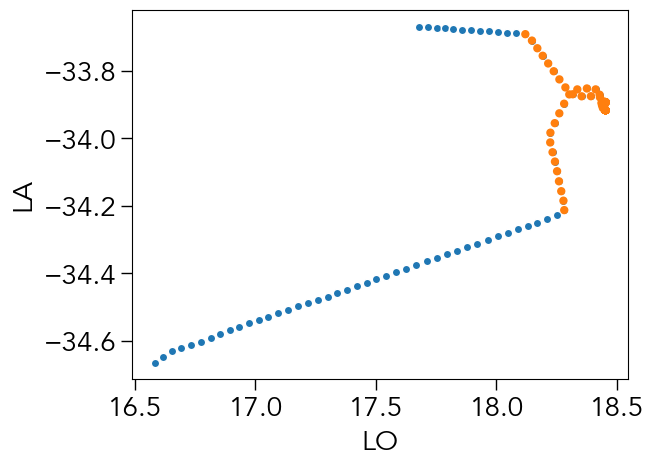

In [581]:
ds.sel(time=slice(np.datetime64('2023-03-15 00:00'), np.datetime64('2023-03-16 00:00'))).plot.scatter(x='LO',y='LA')
ds.sel(time=slice(np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 17:00'))).plot.scatter(x='LO',y='LA',c='C1',ec=None)

## Ship

/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_4482/543510825.py:491: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ik = np.array(np.where(rr[iice] > np.logical_and(0.135,rr[iice]) <= 2.5))
/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_4482/543510825.py:494: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ik = np.array(np.where(rr[iice] > np.logical_and(2.5,rr[iice]) <= 1000))


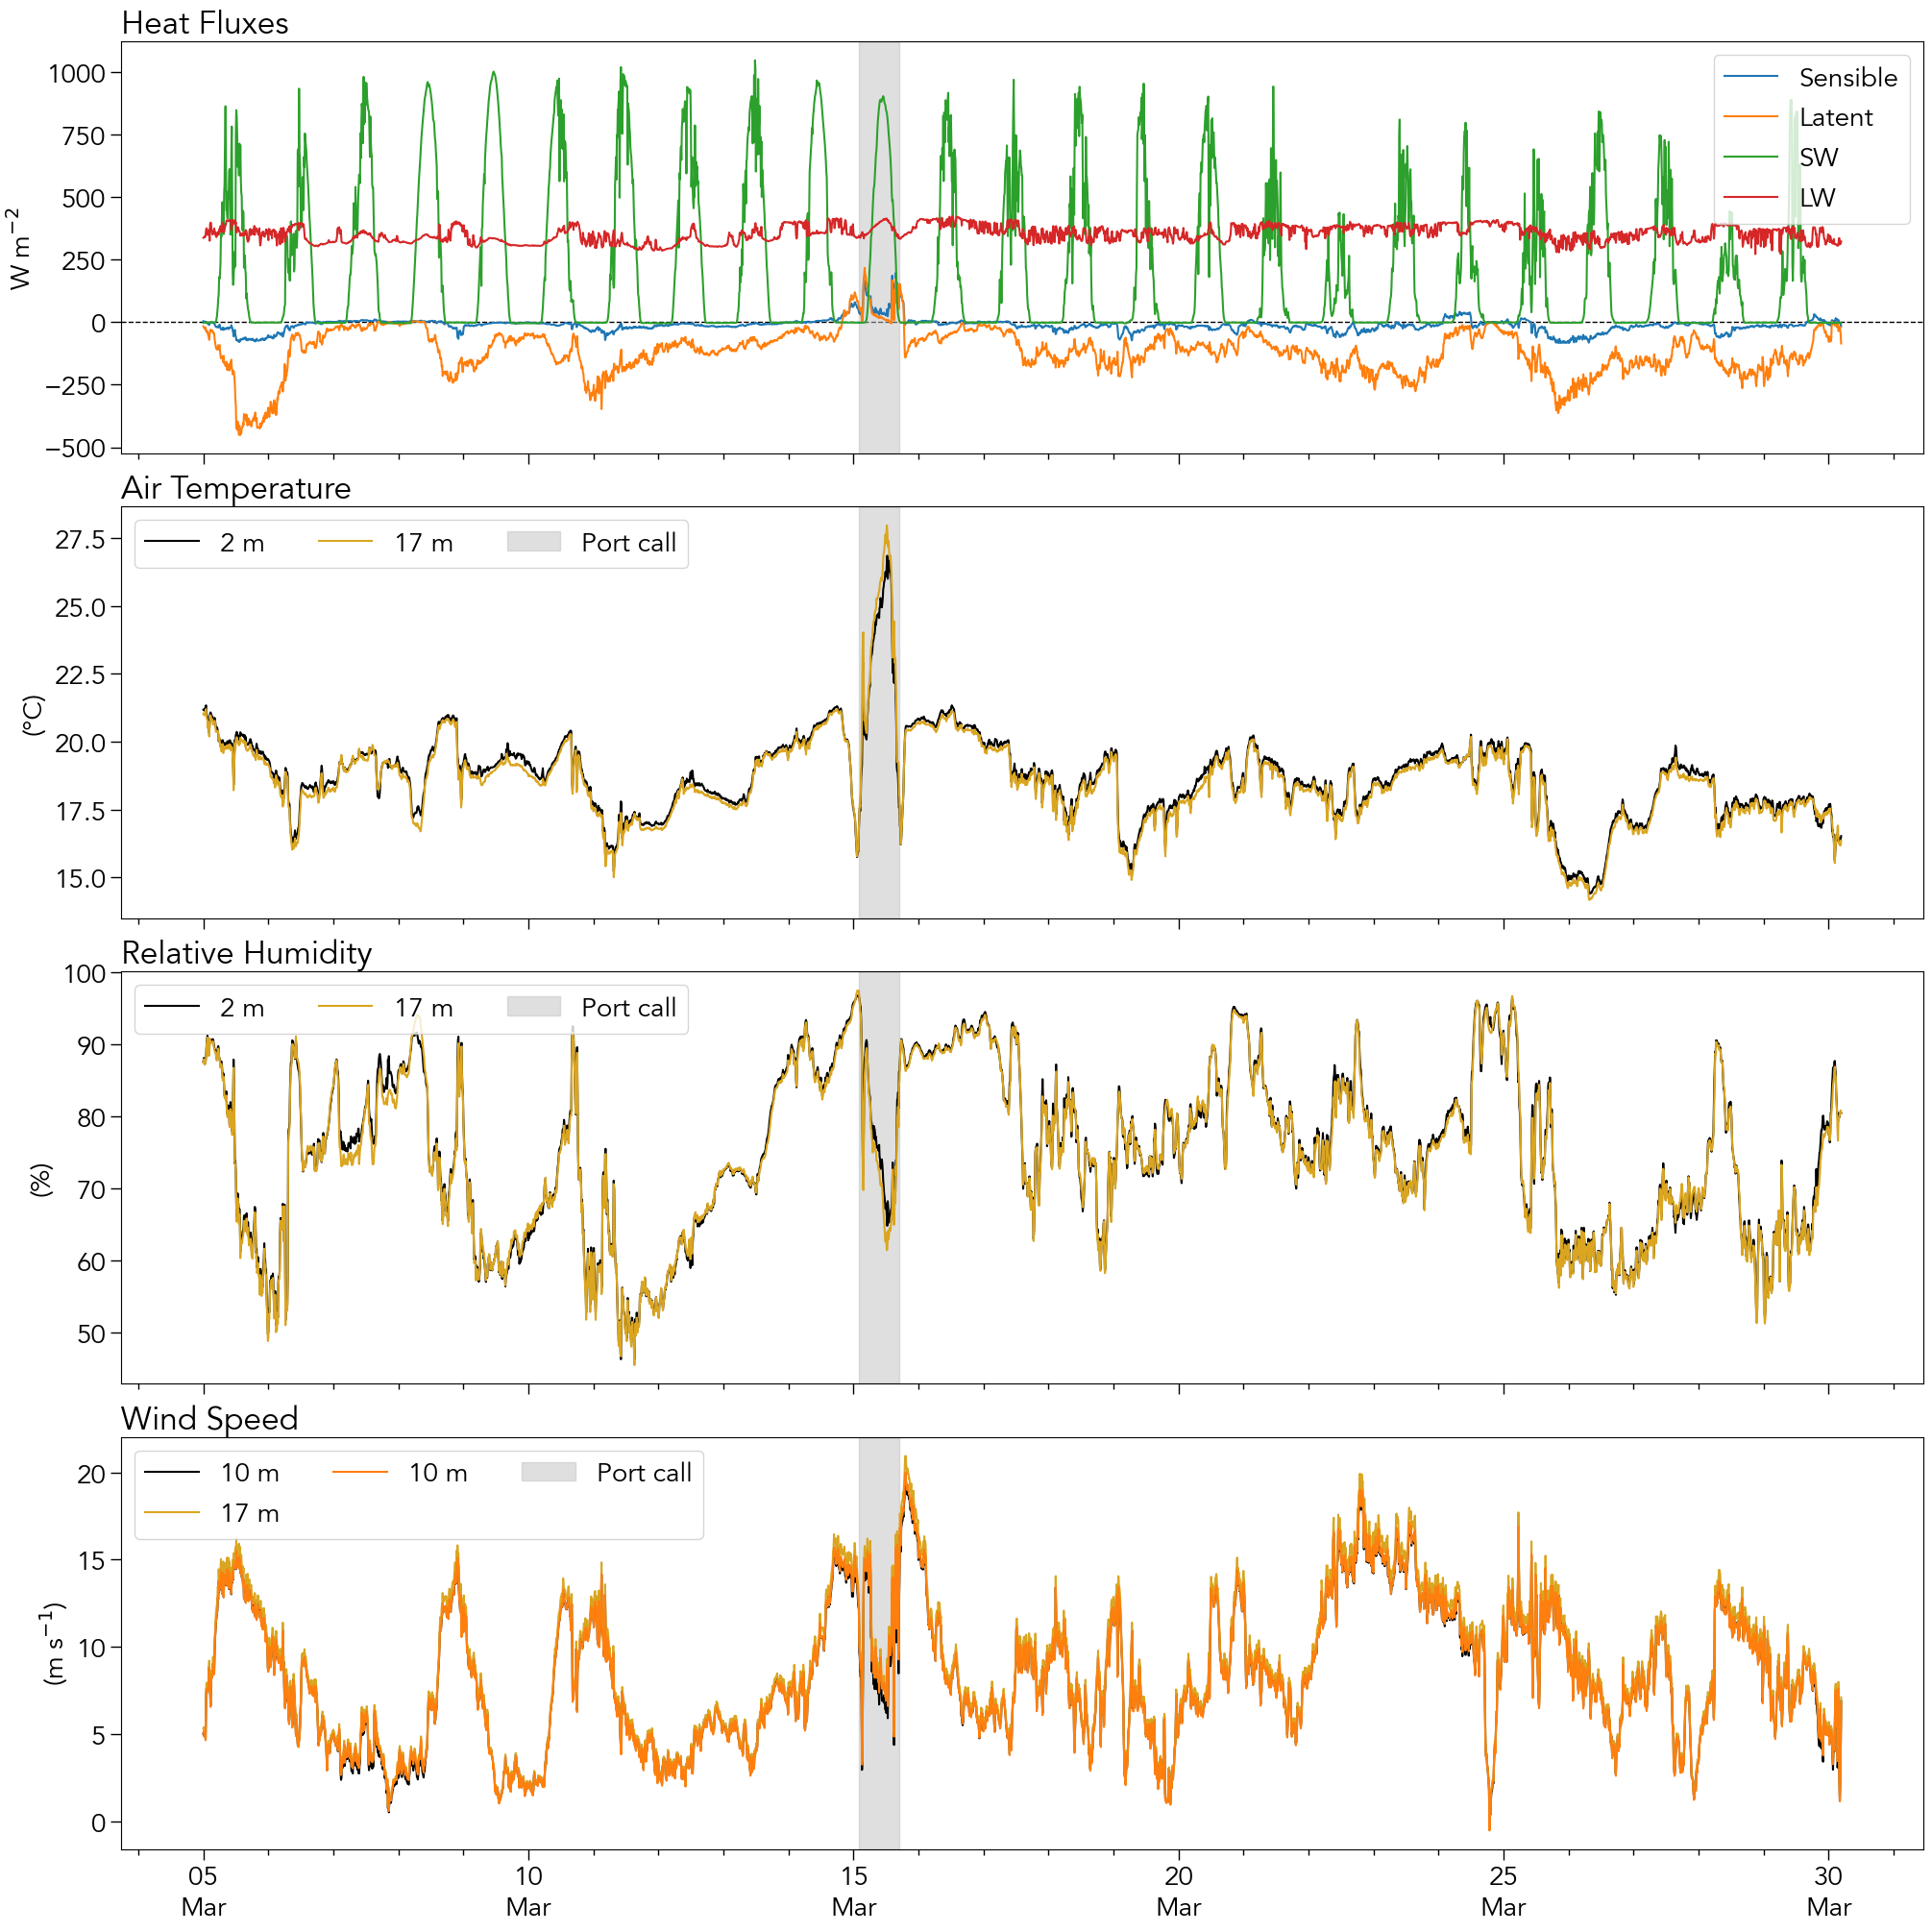

In [600]:
## Ship
jd    = ds['doy'].data
u     = ds['TW'].data
zu    = 17
t     = ds['at'].data
zt    = 17
rh    = ds['rh'].data
zq    = 17
P     = np.ones(len(jd))*ds['BP'].data.mean() #ds['BP'].data * np.nan # This makes a difference!!
ts    = ds['TT'].data
sw_dn = np.zeros(len(jd)) #ds['SW'].data
lw_dn = np.zeros(len(jd)) #ds['LW'].data
lat   = ds['LA'].data
lon   = ds['LO'].data
zi    = 600
rain  = 0 
zts   = -0.5
Ss   = ds['SA'].data

df = pd.DataFrame(coare36vn_zrf_et(u, zu , t, zt, rh, zq, P, ts, sw_dn, lw_dn, lat, lon,jd, zi,rain, Ss, cp=None, sigH=None, zrf_u=10.0, zrf_t=2.0, zrf_q=2.0),columns=variables)

ds['T10'] = ('time'), df['T10']
ds['TrfN'] = ('time'), df['TrfN']
ds['U10'] = ('time'), df['U10']
ds['RH10'] = ('time'), df['RH10']
ds['tau'] = ('time'), df['tau']
ds['hsb'] = ('time'), df['hsb']
ds['hlb'] = ('time'), df['hlb']


fig,ax = plt.subplots(4,1,figsize=(20,20),sharex=True,constrained_layout=True)

c2 = 'k'
c17 = 'goldenrod'

(-ds['hsb']).plot(ax=ax[0],label='Sensible',zorder=2)
(-ds['hlb']).plot(ax=ax[0],label='Latent',zorder=2)
(ds['SW']).plot(ax=ax[0],label='SW',zorder=2)
(ds['LW']).plot(ax=ax[0],label='LW',zorder=2)
ax[0].legend()
ax[0].axhline(0,ls='--',c='k',lw=1,zorder=1)

(ds['T10']).plot(ax=ax[1],label='2 m',c=c2)
(ds['RT']).plot(ax=ax[1],label='17 m',c=c17)
ax[1].legend()

(ds['U10']).plot(ax=ax[3],label='10 m',c=c2)
(ds['TW']).plot(ax=ax[3],label='17 m',c=c17)
(ds['ws10']).plot(ax=ax[3],label='10 m',c='C1')

(ds['RH10']).plot(ax=ax[2],label='2 m',c=c2)
(ds['RH']).plot(ax=ax[2],label='17 m',c=c17)

for i, axs in enumerate(ax):
    axs.set(xlabel='', ylabel=['W m$^{-2}$', '(°C)', '(%)', '(m s$^{-1}$)'][i])
    axs.set_title(['Heat Fluxes','Air Temperature','Relative Humidity','Wind Speed'][i],loc='left')
    y_limits = axs.get_ylim()
    axs.fill([np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 17:00'), np.datetime64('2023-03-15 17:00'), np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 02:00')], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='silver', alpha=0.5,label='Port call')
    axs.set_ylim(y_limits)
    if i != 0:
        axs.legend(loc='upper left',ncol=3)
        
fix_xticks(ax,ds)

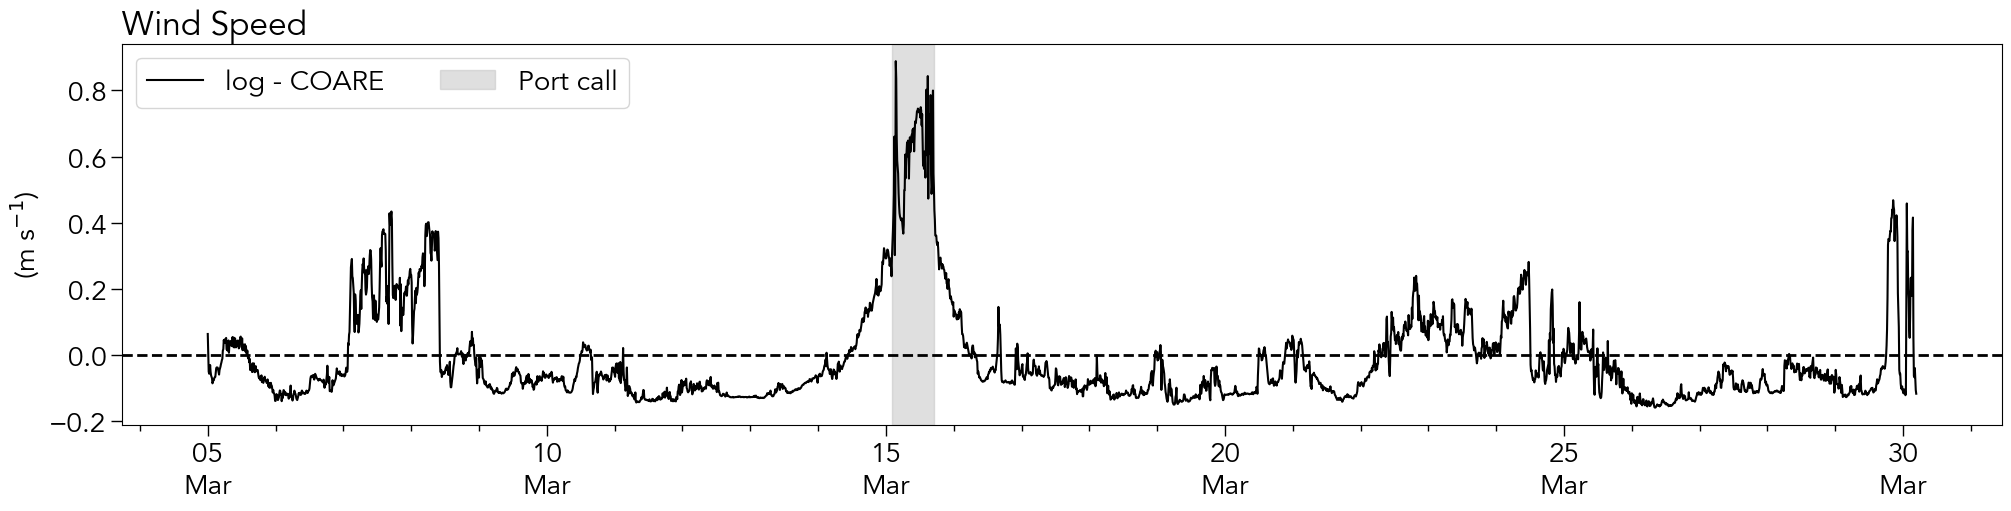

In [605]:
fig,ax = plt.subplots(1,1,figsize=(20,5),sharex=True,constrained_layout=True)

c2 = 'k'
c17 = 'goldenrod'

(ds['ws10']-ds['U10']).plot(ax=ax,label='log - COARE',c=c2)

for i, axs in enumerate([ax]):
    axs.set(xlabel='', ylabel=['(m s$^{-1}$)'][i])
    axs.set_title(['Wind Speed'][i],loc='left')
    y_limits = axs.get_ylim()
    axs.fill([np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 17:00'), np.datetime64('2023-03-15 17:00'), np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 02:00')], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='silver', alpha=0.5,label='Port call')
    axs.set_ylim(y_limits)
    if i == 0:
        axs.legend(loc='upper left',ncol=3)
ax.axhline(0,ls='--',lw=2,c='k')
fix_xticks([ax],ds)

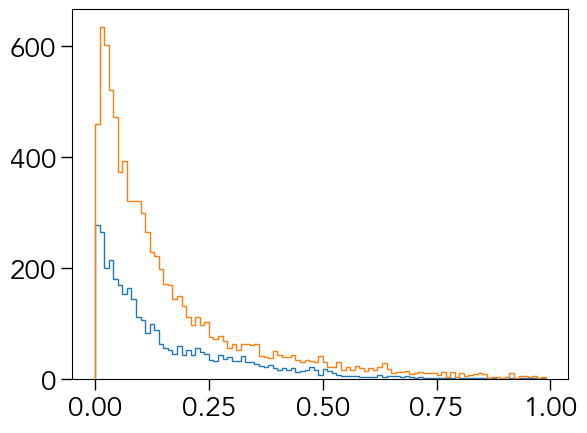

In [504]:
_=plt.hist(ds['tau'],bins=np.arange(0,1,0.01),histtype='step')
_=plt.hist(sb_k['tau'],bins=np.arange(0,1,0.01),histtype='step')

In [ ]:
_=plt.hist(ds['tau'],bins=np.arange(0,1,0.01),histtype='step')
_=plt.hist(sb_k['tau'],bins=np.arange(0,1,0.01),histtype='step')

<span style='font-size: 20px;'><xarray.DataArray 'hlb' ()>
array(49.43306573)</span>

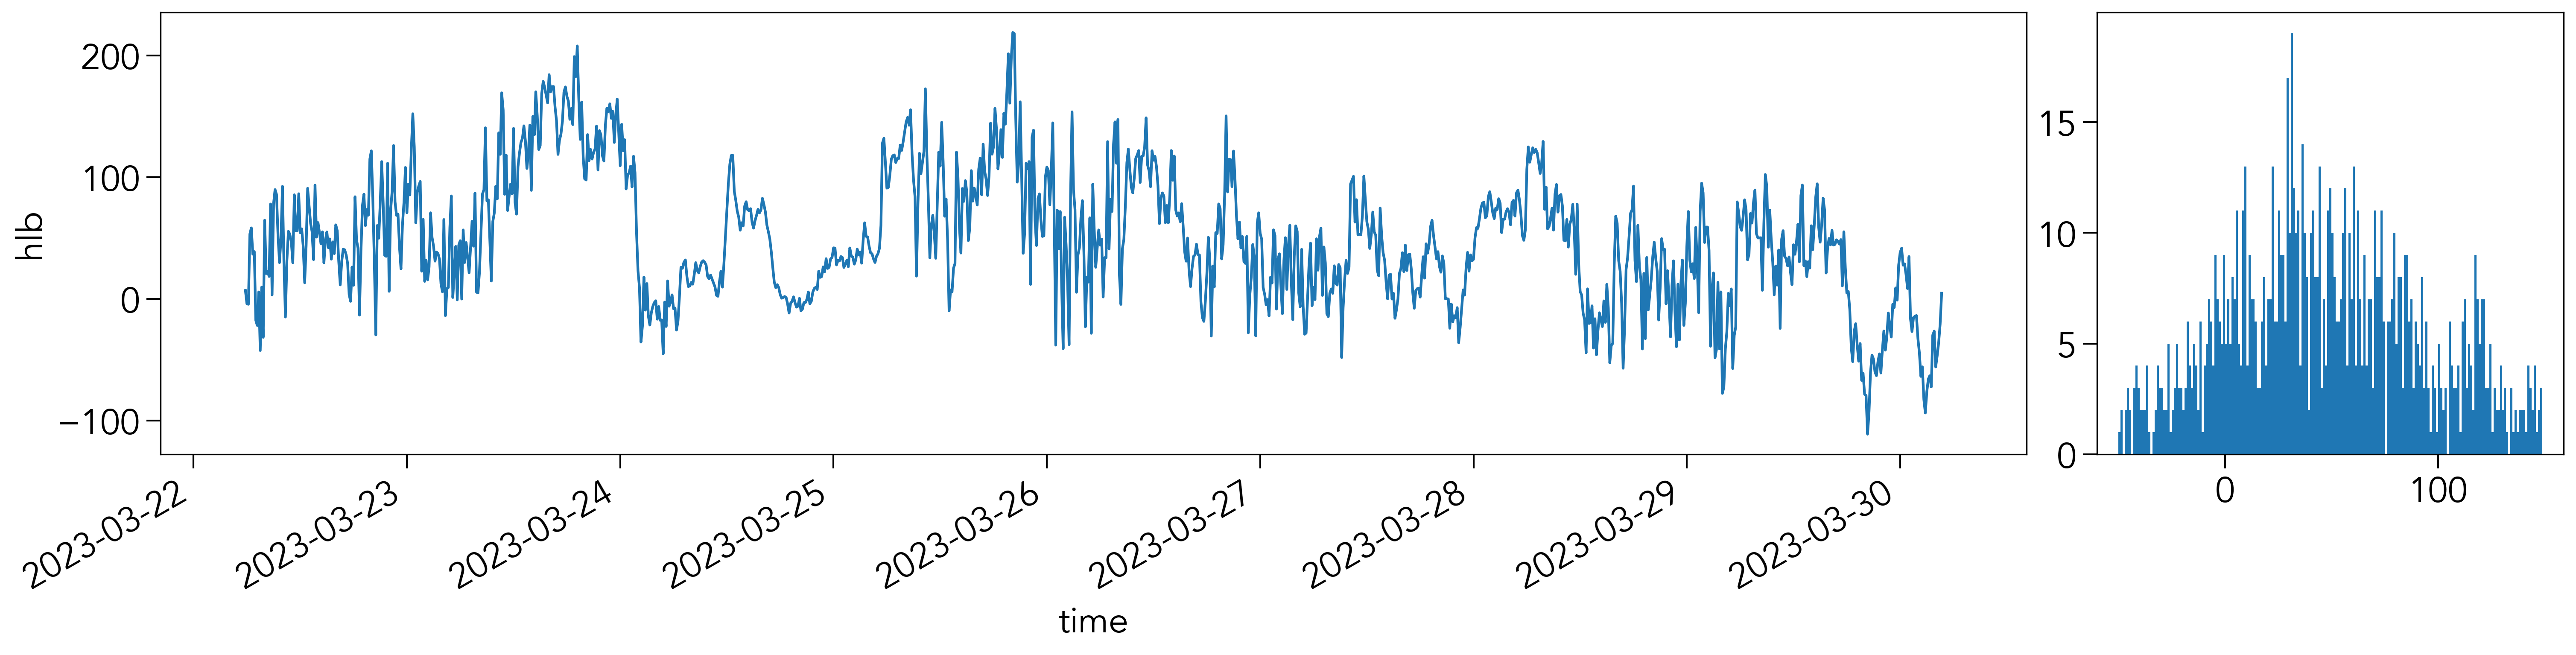

In [515]:
figprops = dict(figsize=(20, 5), dpi=300)
fig = plt.figure(layout="constrained",**figprops)
spec = fig.add_gridspec(nrows=1,ncols=5)

ax = fig.add_subplot(spec[0, :4])
bx = fig.add_subplot(spec[0, 4])

(ds['hlb']-sb_k['hlb']).plot(ax=ax)
_=bx.hist((ds['hlb']-sb_k['hlb']),bins=np.arange(-50,150,1))

print((ds['hlb']-sb_k['hlb']).mean())

In [599]:
-6.4 * 0.01

-0.064

## Sailbuoy

In [538]:
######## PimPim QUICCHE ########
sb_k = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/sailbuoy/PimPim/full/DATA.nc')
sb_k['doy'] = xr.DataArray(mdates.date2num(sb_k['time']) - mdates.date2num(np.datetime64('2023-01-02')),dims='time')
sb_k['mday'] = xr.DataArray(mdates.date2num(sb_k['time']) - mdates.date2num(sb_k['time'].values[0]),dims='time')
sb_k = sb_k.set_coords('doy')

In [ ]:
ds

/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_4482/543510825.py:491: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ik = np.array(np.where(rr[iice] > np.logical_and(0.135,rr[iice]) <= 2.5))
/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_4482/543510825.py:494: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ik = np.array(np.where(rr[iice] > np.logical_and(2.5,rr[iice]) <= 1000))


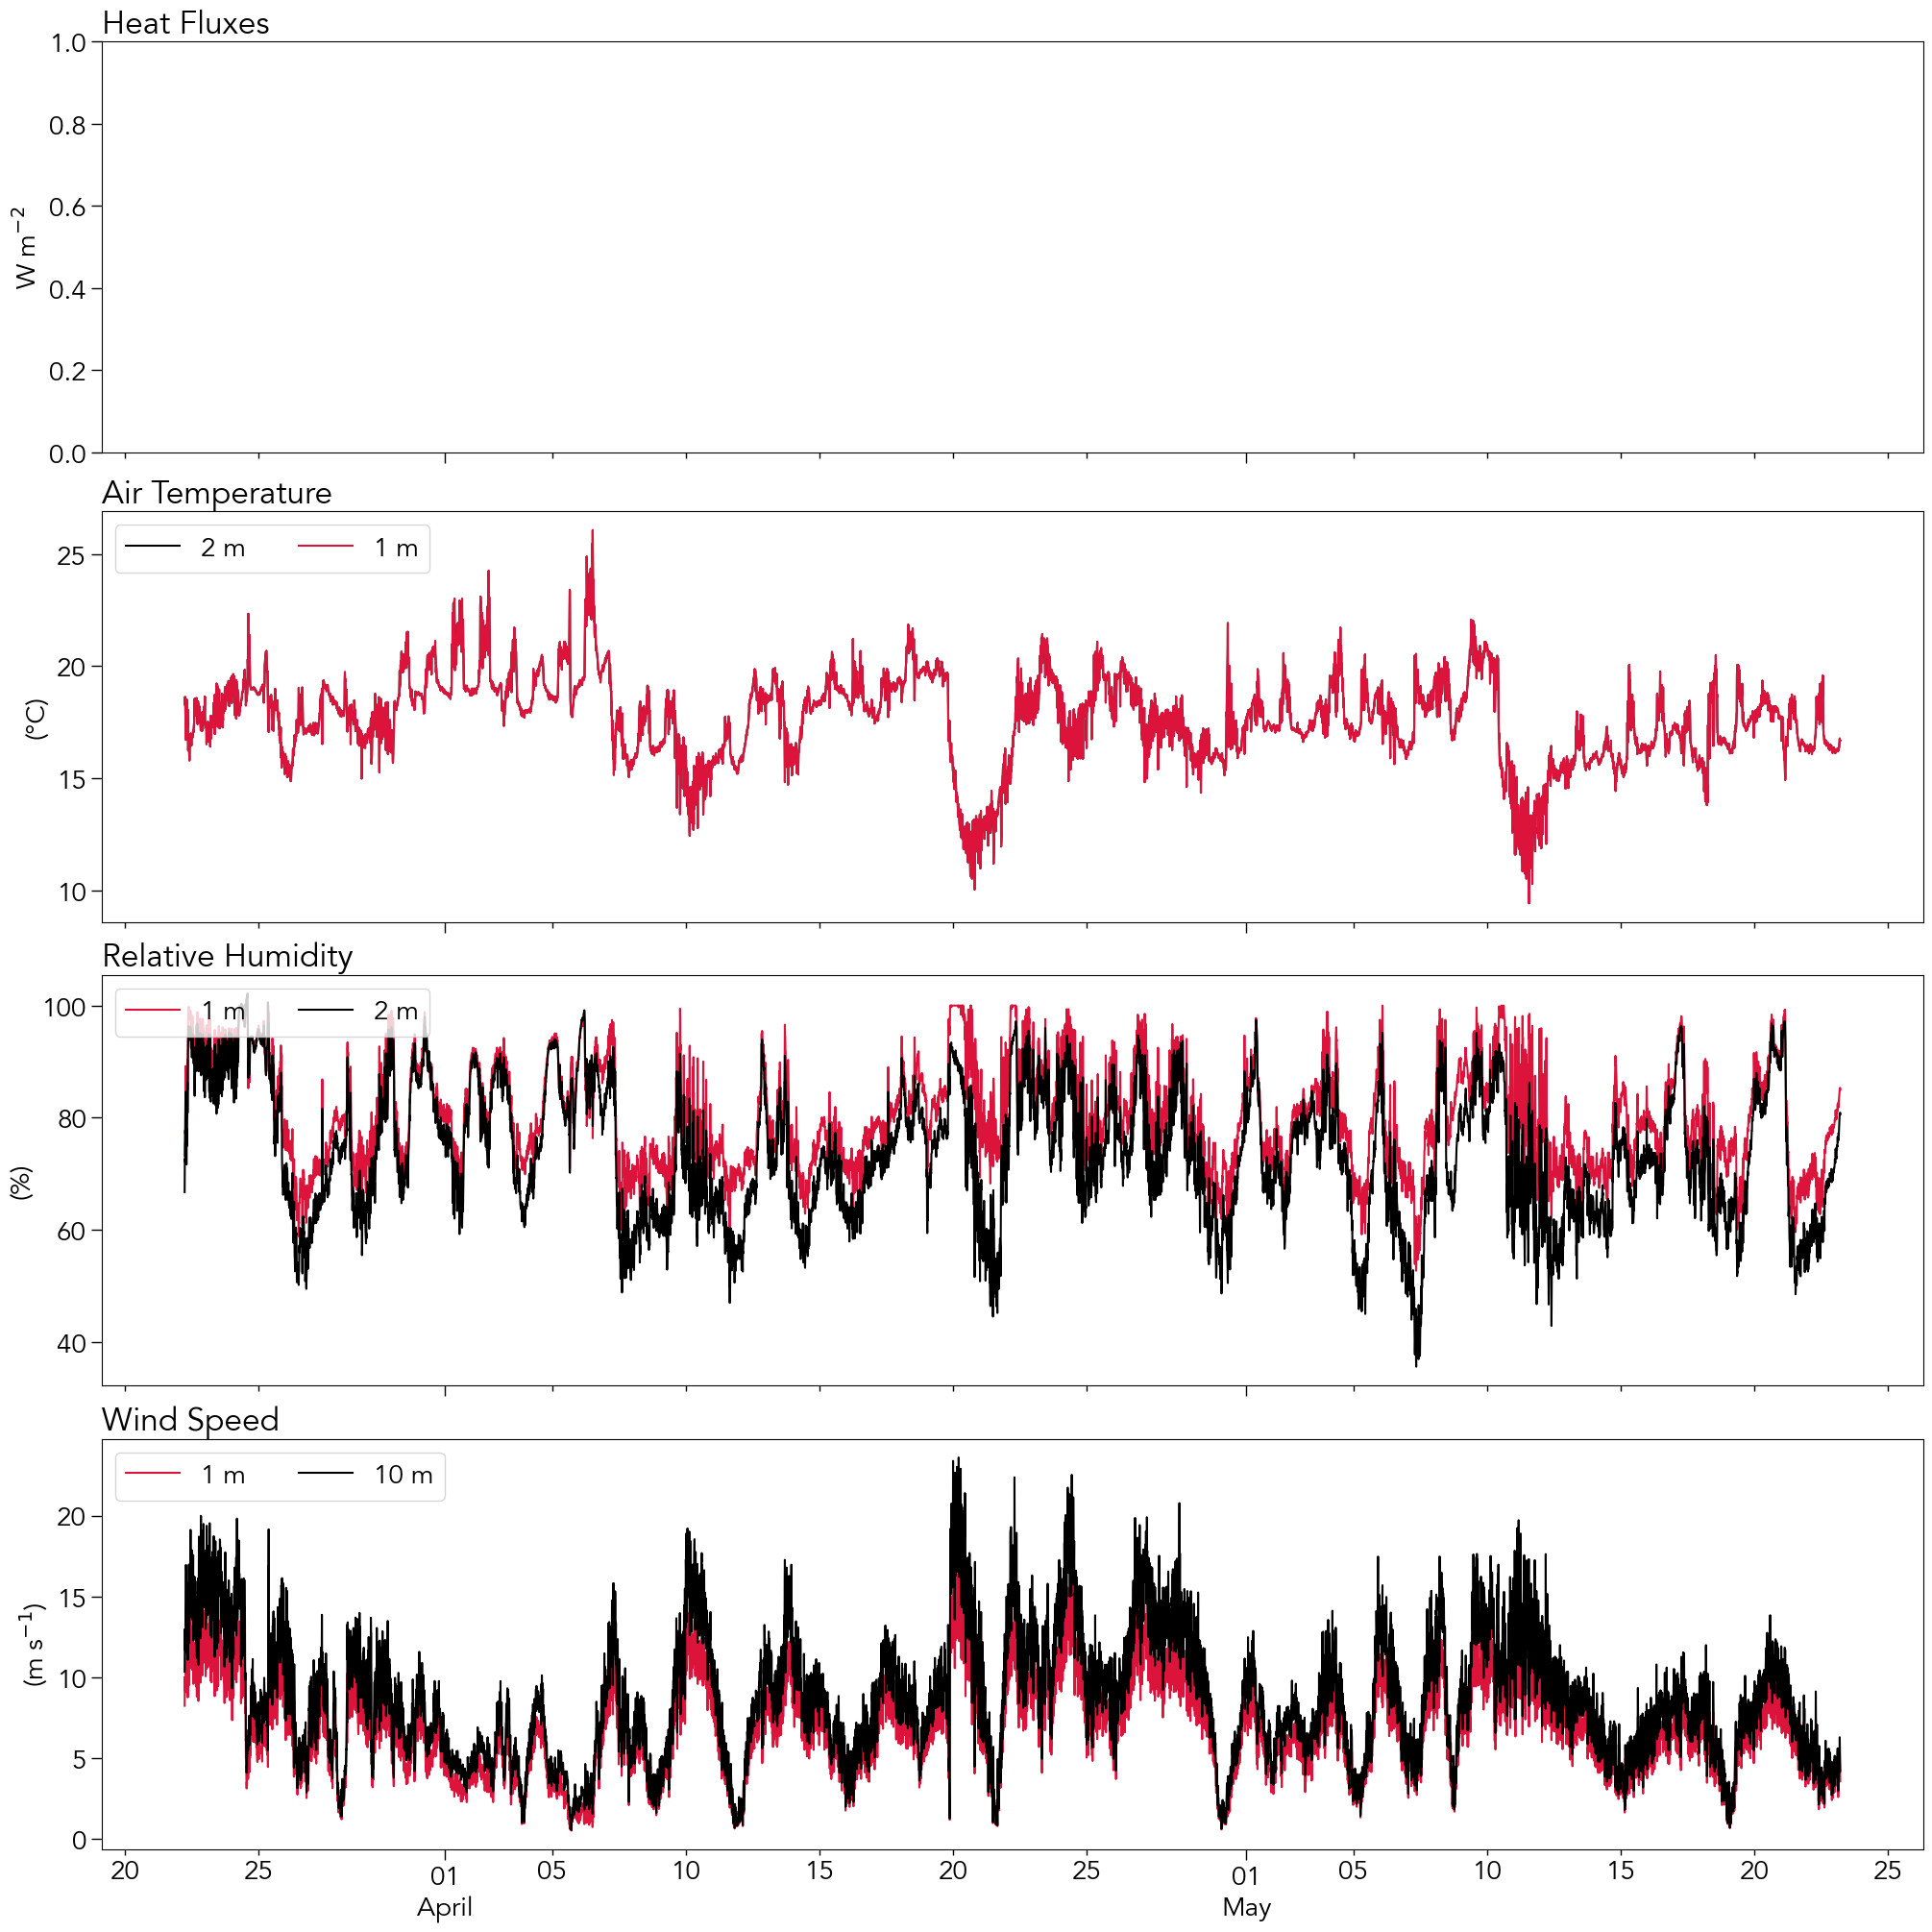

In [606]:
## Sailbuoy
jd    = sb_k['doy'].interpolate_na('time').data
u     = sb_k['wind_speed'].interpolate_na('time').data
zu    = 1
t     = sb_k['air_t'].interpolate_na('time').data
zt    = 10
rh    = sb_k['rh'].interpolate_na('time').data
zq    = 1
P     = np.ones(len(jd))*1013
ts    = sb_k['sst'].interpolate_na('time').values
sw_dn = np.zeros(len(jd))
lw_dn = np.zeros(len(jd))
lat   = sb_k['latitude'].interpolate_na('time').data
lon   = sb_k['longitude'].interpolate_na('time').data
zi    = 600
rain  = 0 
zts   = -1
Ss   = sb_k['sss'].interpolate_na('time').data

df = pd.DataFrame(coare36vn_zrf_et(u, zu , t, zt, rh, zq, P, ts, sw_dn, lw_dn, lat, lon,jd, zi,rain, Ss, cp=None, sigH=None, zrf_u=10.0, zrf_t=2.0, zrf_q=2.0),columns=variables)


sb_k['T10'] = ('time'), df['T10']
sb_k['TrfN'] = ('time'), df['TrfN']
sb_k['U10'] = ('time'), df['U10']
sb_k['RH10'] = ('time'), df['RH10']
sb_k['tau'] = ('time'), df['tau']
sb_k['hsb'] = ('time'), df['hsb']
sb_k['hlb'] = ('time'), df['hlb']


fig,ax = plt.subplots(4,1,figsize=(20,20),sharex=True,constrained_layout=True)

# (-sb_k['hsb']).plot(ax=ax[0],label='Sensible',zorder=2)
# (-sb_k['hlb']).plot(ax=ax[0],label='Latent',zorder=2)
# (sb_k['SW']).plot(ax=ax[0],label='SW',zorder=2)
# (sb_k['LW']).plot(ax=ax[0],label='LW',zorder=2)
# ax[0].legend()
# ax[0].axhline(0,ls='--',c='k',lw=1,zorder=1)

(sb_k['T10']).plot(ax=ax[1],label='2 m',c='k')
(sb_k['air_t']).plot(ax=ax[1],label='1 m',c=ppc)
ax[1].legend()

(sb_k['wind_speed']).plot(ax=ax[3],label='1 m',c=ppc)
(sb_k['U10']).plot(ax=ax[3],label='10 m',c='k')

(sb_k['rh']).plot(ax=ax[2],label='1 m',c=ppc)
(sb_k['RH10']).plot(ax=ax[2],label='2 m',c='k')

for i, axs in enumerate(ax):
    axs.set(xlabel='', ylabel=['W m$^{-2}$', '(°C)', '(%)', '(m s$^{-1}$)'][i])
    axs.set_title(['Heat Fluxes','Air Temperature','Relative Humidity','Wind Speed'][i],loc='left')
    # y_limits = axs.get_ylim()
    # axs.fill([np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 17:00'), np.datetime64('2023-03-15 17:00'), np.datetime64('2023-03-15 02:00'), np.datetime64('2023-03-15 02:00')], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='silver', alpha=0.5,label='Port call')
    # axs.set_ylim(y_limits)
    if i != 0:
        axs.legend(loc='upper left',ncol=3)
        
fix_xticks(ax,sb_k)

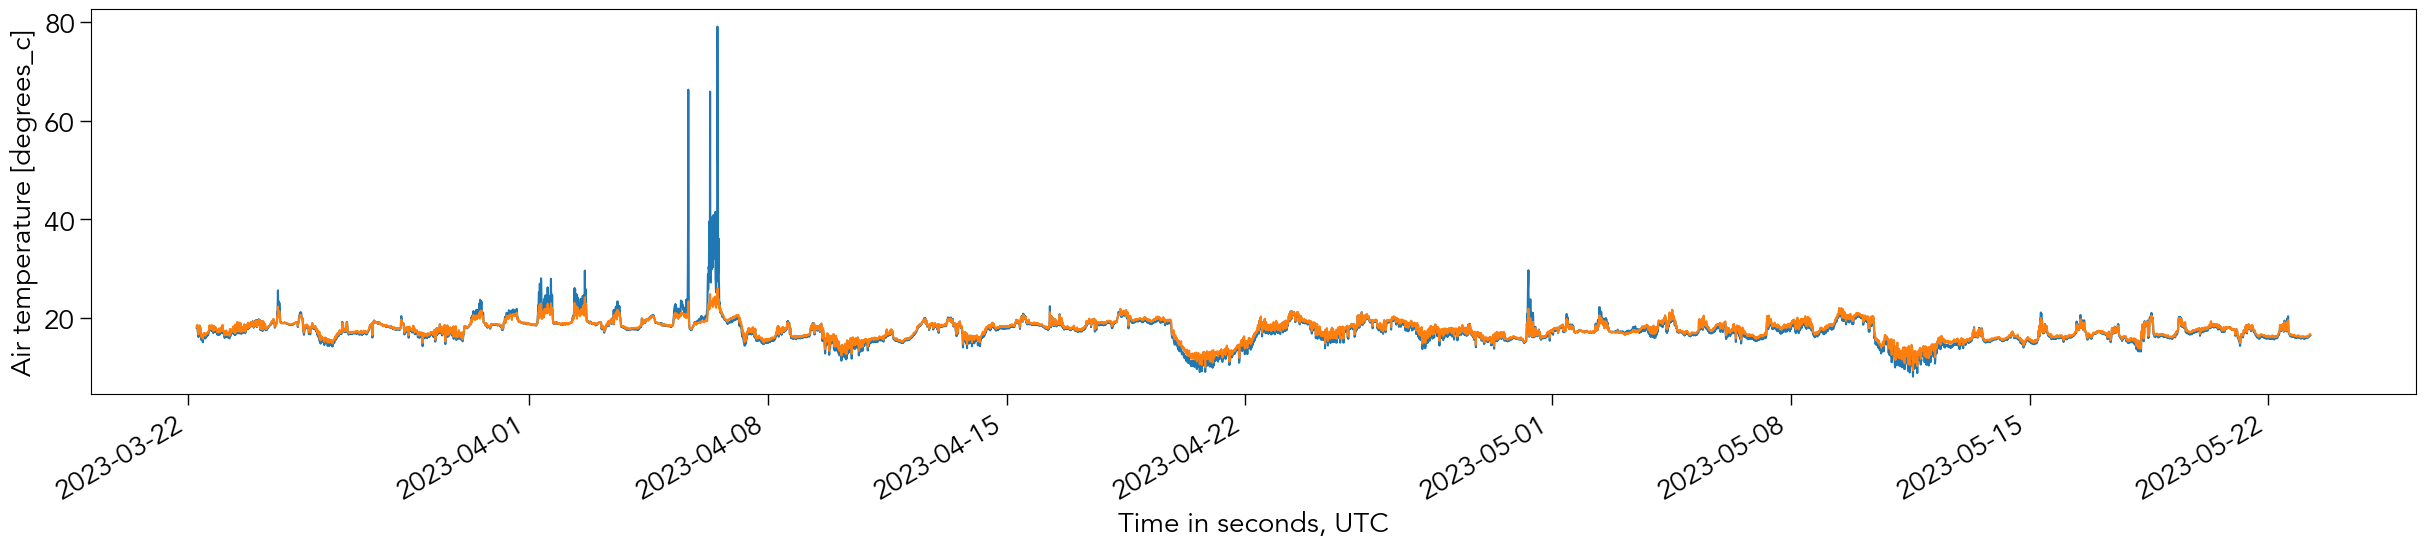

In [496]:
sb_k['T10'].plot(figsize=(30,5))
sb_k['air_t'].interpolate_na('time').plot()

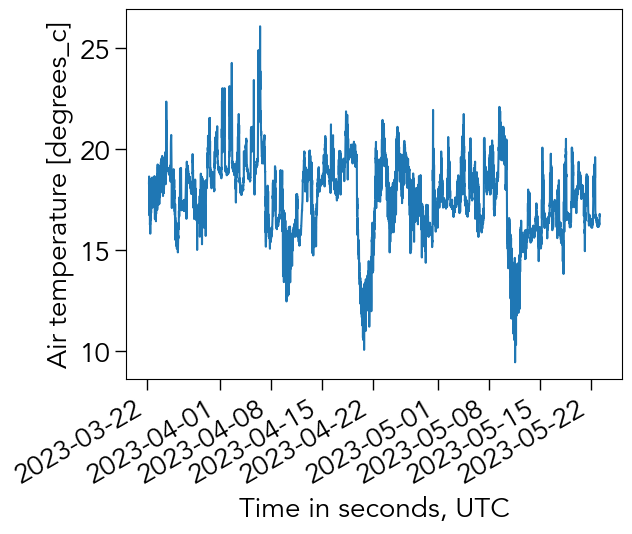

In [485]:
sb_k['air_t'].plot()

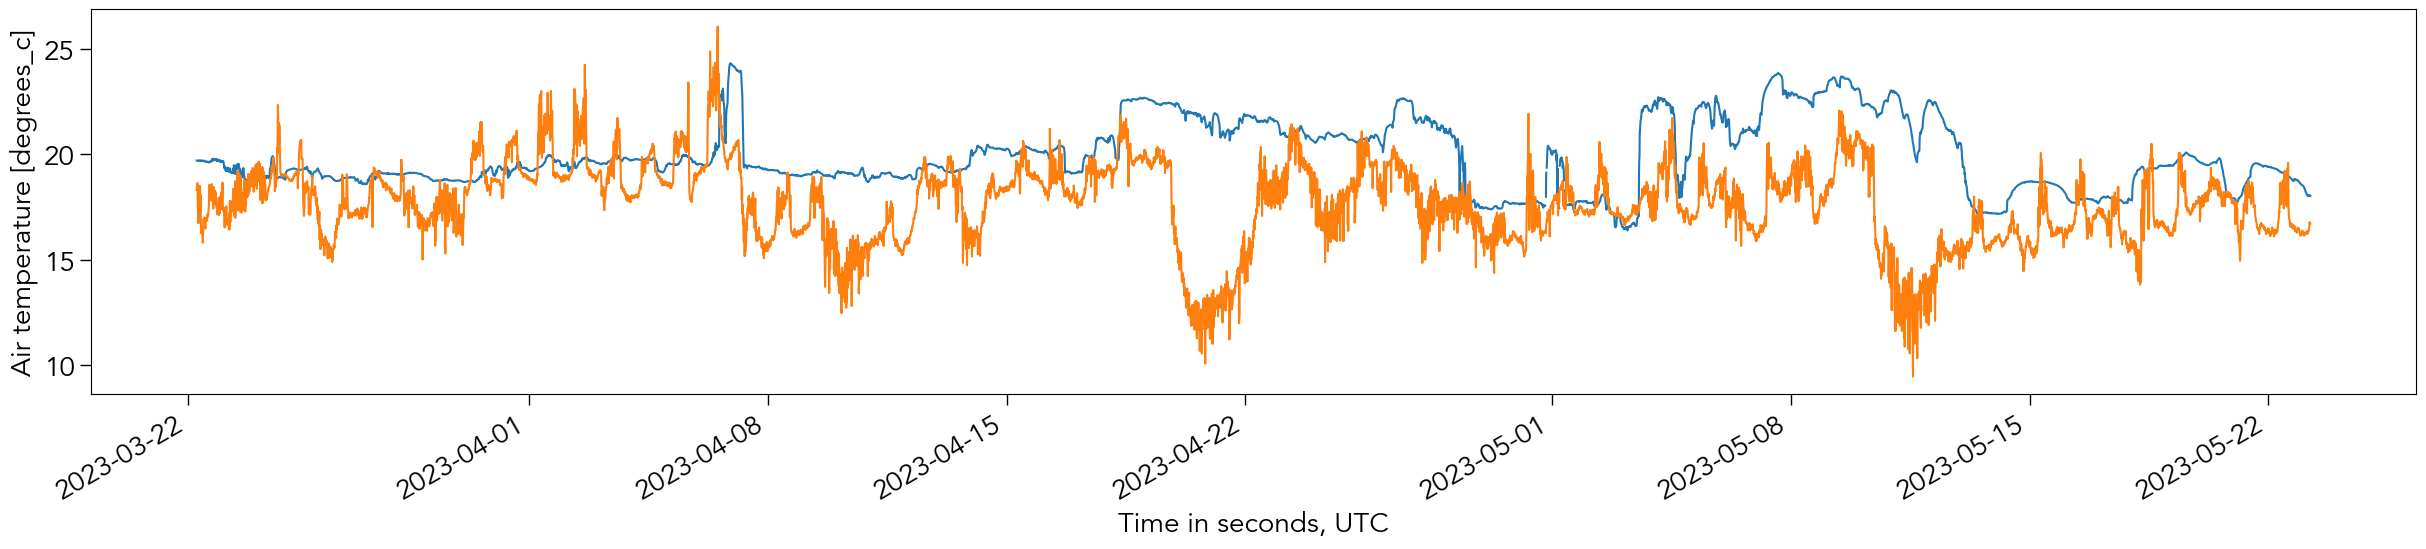

In [480]:
sb_k['sst'].plot(figsize=(30,5))
sb_k['air_t'].plot()


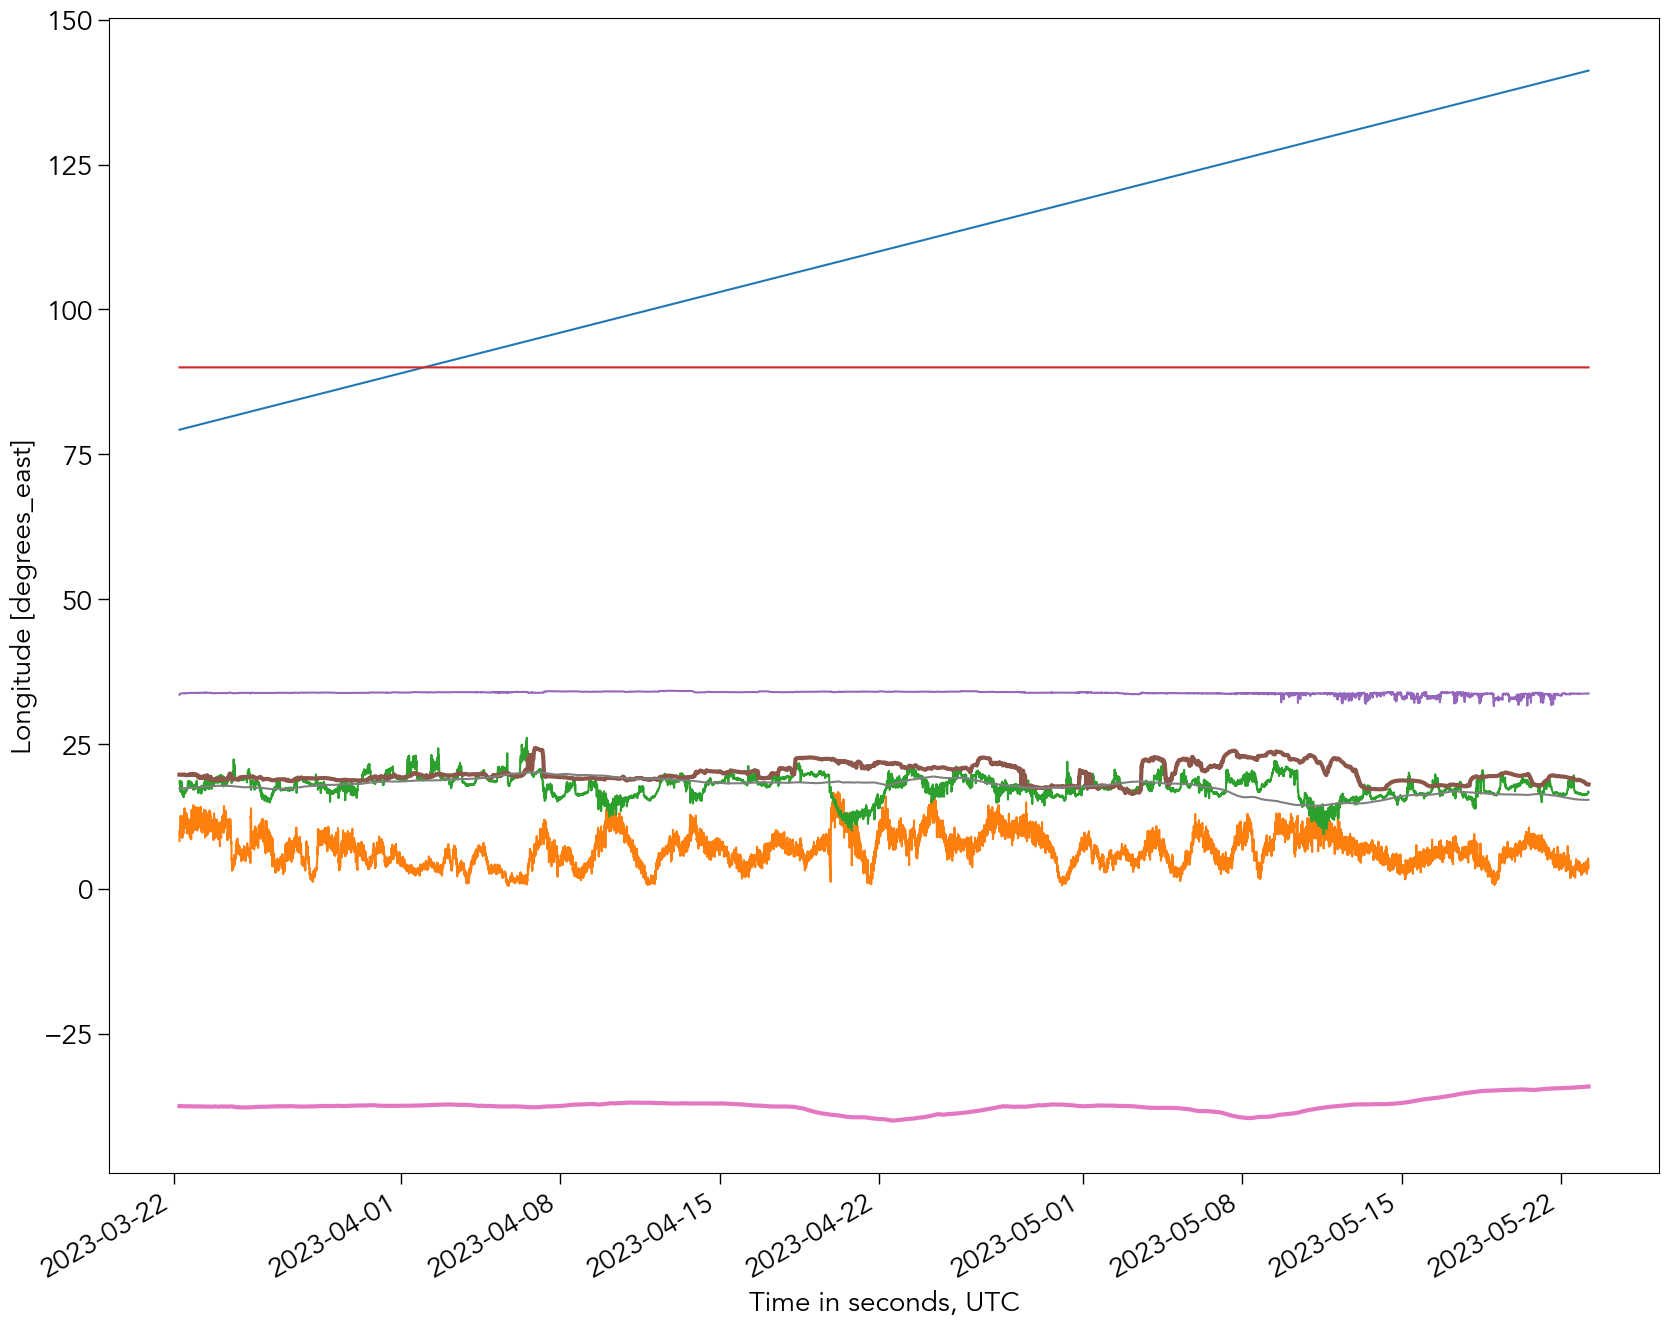

In [440]:
sb_k['doy'].plot(figsize=(20,15))
sb_k['wind_speed'].plot()
sb_k['air_t'].plot()
plt.plot(sb_k.time.values,np.ones(len(jd))*90)
sb_k['sss'].plot()
sb_k['sst'].plot(lw=3)
sb_k['latitude'].plot(lw=3)
sb_k['longitude'].plot()


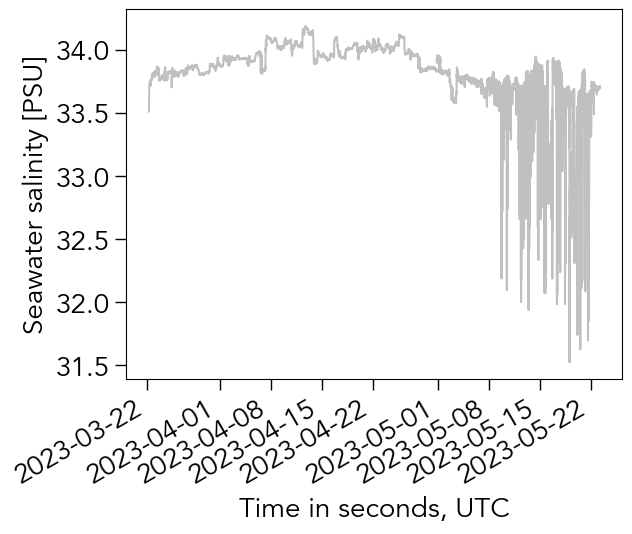

In [387]:
sb_k['sss'].plot(c='silver')


In [ ]:
ts = 'surface temp'
t = 'air temp'
Ss = 'sss'
u = 'wind speed'

us = 0 * u
grav = grv(lat)
cpa = 1004.67
lapse = grav / cpa
von = 0.4
zu = 17
T2K = 273.16
ta = t + T2K
zt = 17
zrf_t = 2
zeta = np.multiply(np.multiply(np.multiply(von,grav),zu) / ta,(tsr + np.multiply(0.61 * ta,qsr))) / (usr ** 2)
L = zu / zeta
fdg = 1.0
visa = 1.326e-05 * (1 + np.multiply(0.006542,t) + 8.301e-06 * t ** 2 - 4.84e-09 * t ** 3)
    zetau = np.multiply(np.multiply(CC,Ribu),(1 + 27 / 9 * Ribu / CC))

L10 = zu / zetau

ut = np.sqrt(du ** 2 + gust ** 2)
u10 = np.multiply(ut,np.log(10 / 0.0001)) / np.log(zu / 0.0001)
usr = 0.035 * u10
zo10 = 0.011 * usr ** 2.0 / grav + 0.11 * visa / usr
Cd10 = (von / np.log(10.0 / zo10)) ** 2
Ch10 = 0.00115
Ct10 = Ch10 / np.sqrt(Cd10)
    
    
zot10 = 10.0 / np.exp(von / Ct10)

psiT = psit_26(zt / L)

psirfT = psit_26(zrf_t / L)
dT_skin = 0.3
dT = ts - t - np.multiply(lapse,zt)
jcoolx = 1
N = np.size(u)
jcool = jcoolx * np.ones(N)
Tf = - 0.0575 * Ss + 0.00171052 * Ss ** 1.5 - np.multiply(0.0002154996 * Ss,Ss)

iice = np.array(np.where(ts < Tf))
jcool[iice] = 0

tsr = np.multiply(- (dT - np.multiply(dT_skin,jcool)),von) * fdg / (np.log(zt / zot10) - psit_26(zt / L10))

Trf = t + np.multiply(tsr / von,(np.log(zrf_t / zt) - psirfT + psiT)) + np.multiply(lapse,(zt - zrf_t))


In [ ]:
def psit_26(zeta = None): 
    # computes temperature structure function
    dzeta = np.minimum(50,0.35 * zeta)
    psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
    k = np.array(np.where(zeta < 0))
    x = (1 - 15 * zeta[k]) ** 0.5
    psik = 2 * np.log((1 + x) / 2)
    x = (1 - 34.15 * zeta[k]) ** 0.3333
    psic = 1.5 * np.log((1 + x + x ** 2) / 3) - np.sqrt(3) * np.arctan((1 + 2 * x) / np.sqrt(3)) + 4 * np.arctan(1) / np.sqrt(3)
    f = zeta[k] ** 2.0 / (1 + zeta[k] ** 2)
    psi[k] = np.multiply((1 - f),psik) + np.multiply(f,psic)
    return psi

In [ ]:

psiT = psit_26(zt / L)

psirfT = psit_26(zrf_t / L)
dT_skin = 0.3

tsr = np.multiply(- (dT - np.multiply(dT_skin,jcool)),von) * fdg / (np.log(zt / zot10) - psit_26(zt / L10))

Trf = t + np.multiply(tsr / von,(np.log(zrf_t / zt) - psirfT + psiT)) + np.multiply(lapse,(zt - zrf_t))
